# Processamento de Linguagem Natural - Instituto Metrópole Digital 
### Etapa 1 - Análise de Sentimento do Twitter dos presidenciáveis de 2023 

- Docente:
    - Dr. Elias Jacob de Menezes Neto
- Discentes:
    - Igor Michael Araujo de Macedo
    - Keven Alison dos Santos Bezerra
    - Larissa Kelmer de Menezes Silva
    - Vinícius Soares Fernandes

Este notebook tem como objetivo o desenvolvimento da avaliação 1 da displina IMD1107 - Processamento de Linguagem Natural, cujo estudo se baseia na coleta e tratamento de dados de um data set PLN, realizando as principais etapas de limpeza de dados.

A ideia em torno dos dados escolhidos para este projeto se baseia em observar o comportamento dos principais candidatos à Presidência do Brasil, Lula e Bolsonaro, através do conteúdo postado em suas respectivas páginas do twitter.

## Sumário

1. [Configurações Iniciais](#config-inic)
2. [Pré-processamento](#preprocessamento)


## Configurações Iniciais

Inicialmente foi realizada a configuração geral do nosso ambiente de trabalho, realizando a importação dos dados e bibliotecas necessárias para sua devida execução no contexto do tema e da área de PLN.

### Configurações Gerais

Inclui a instalação de pacotes, importação de bibliotecas, download de recursos.

In [2]:
import os
# Detect if we are using Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')

In [3]:
# Instalação dos pacotes necessários

!pip install -qq transformers
!pip install unidecode
!pip install enelvo
!pip install wordcloud
!python -m spacy download pt_core_news_sm
#!pip install --upgrade spacy
!pip install -r requirements.txt
!pip install aiohttp_socks
!pip install fake_useragent
!pip install googletransx

#! git clone https://bitbucket.org/HBrum/tweetsentbr.git ----> get emojis sentiments

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     -- ------------------------------------- 0.7/13.0 MB 14.2 MB/s eta 0:00:01
     ---- ----------------------------------- 1.6/13.0 MB 16.8 MB/s eta 0:00:01
     ------- -------------------------------- 2.4/13.0 MB 19.3 MB/s eta 0:00:01
     ---------- ----------------------------- 3.4/13.0 MB 19.5 MB/s eta 0:00:01
     ----------- ---------------------------- 3.9/13.0 MB 19.1 MB/s eta 0:00:01
     ------------- -------------------------- 4.5/13.0 MB 16.8 MB/s eta 0:00:01
     ---------------- ----------------------- 5.3/13.0 MB 16.8 MB/s eta 0:00:01
     ------------------- -------------------- 6.4/13.0 MB 17.9 MB/s eta 0:00:01
     ---------------------- ----------------- 7.4/13.0 MB 18.2 MB/s eta 0:00:01
     ------------------------- -------------- 8.4/13.0 MB 18.5 MB/s eta 0:00:01
     ---------------------------- ----------- 9.3/13.0 MB 18.5 MB/s eta 0:00:01
     ------------------------------- ------- 10.

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\larissa.silva\AppData\Local\Temp\pip-install-k7d5tava\cffi_2207edc95b7241b594fb3c24b52757de\setup.py", line 127, in <module>
          if sys.platform == 'win32' and uses_msvc():
        File "C:\Users\larissa.silva\AppData\Local\Temp\pip-install-k7d5tava\cffi_2207edc95b7241b594fb3c24b52757de\setup.py", line 105, in uses_msvc
          return config.try_compile('#ifndef _MSC_VER\n#error "not MSVC"\n#endif')
        File "C:\Users\larissa.silva\AppData\Local\miniconda3\envs\vm\lib\site-packages\setuptools\_distutils\command\config.py", line 220, in try_compile
          self._compile(body, headers, include_dirs, lang)
        File "C:\Users\larissa.silva\AppData\Local\miniconda3\env

In [29]:
# Importação das bibliotecas necessárias

%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import unidecode
import re
import os
from string import punctuation
from enelvo.normaliser import Normaliser
from nltk import ngrams
import nltk
from nltk import tokenize
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import statistics
import string
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [280]:
nlp = spacy.load('pt_core_news_sm')
nltk.download('stopwords')
nltk.download('punkt')
#nltk.download('all')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\larissa.silva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\larissa.silva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [236]:
pd.set_option('display.max_colwidth', None)

### Configurações da API e Requisição de Dados

A fim de criar um dataset que atenda aos propósitos deste trabalho, a análise de sentimento de tuítes, 
fez-se uso de uma ferramenta na linguagem Python, a [Optimized-Modified-GetOldTweets3 (OMGOT)](https://github.com/marquisvictor/Optimized-Modified-GetOldTweets3-OMGOT/tree/master), baseada 
na própria [Application Programming Interface (API)](https://developer.twitter.com/en/docs/twitter-api), ou Interface de Programação de Aplicação, do Twitter. 
O diferencial dessa plataform ́e a não necessidade de se ter uma conta na plataforma, a quantidade de tuítes 
retornados na busca - a API do Twitter se limita a 500 por mês, e a possibilidade de que buscas mais 
extensas sejam feitas em contas de usuários terceiros. Por ser a OMGOT  ́e uma ferramenta derivada da 
API do Twitter, o retorno da sua busca mantém os mesmos parâmetros das reornadas pela outra ferramenta.

> Observação: Apesar de retornar grandes volumes de dados, a OMGOT não exclui a possibilidade de não ter 
conseguido devolver todos os tuítes buscados.



##### Fomato para requisição da API
> ! python cli.py --username <user> --until/since <ano-mês-dia> -o <nome_arquivo.extensão> --csv <extensão>

In [6]:
os.chdir(r'.\pln\projeto_etapa1')

print(os.getcwd())

# Clone the entire repo
!git clone -b fix-api https://github.com/marquisvictor/Optimized-Modified-GetOldTweets3-OMGOT.git

C:\Users\larissa.silva\Documents\pessoal\UFRN\2024.1\pln\projeto_etapa1


Cloning into 'Optimized-Modified-GetOldTweets3-OMGOT'...


In [38]:
os.chdir('Optimized-Modified-GetOldTweets3-OMGOT')
os.chdir('GetOldTweets3-0.0.10')
os.chdir('..')

print(os.getcwd())

C:\Users\larissa.silva\Documents\pessoal\UFRN\2024.1\pln\projeto_etapa1


#### Importação do DataFrame com dados de cada candidato

> Inclui a seleção de features do DF, para incluir apenas o nome do candidato e o texto dos tuítes

#### Lula

In [ ]:
#!python cli.py --username "LulaOficial" --until "2018-04-07" -o lula1.csv --csv
#!python cli.py --username "LulaOficial" --since "2024-04-01" -o lula2.csv --csv
#lula1 = pd.read_csv('/content/drive/MyDrive/UFRN/2024/2024.1/pln/projeto_etapa1/lulaxboroliro/lula1.csv')
#lula2 = pd.read_csv('/content/drive/MyDrive/UFRN/2024/2024.1/pln/projeto_etapa1/lulaxboroliro/lula2.csv')
#lula_df = pd.concat([lula1, lula2])
#lula_df = lula_df.sort_values(by=['created_at'], ascending=False)

In [40]:
lula_df = pd.read_csv('.\data\lula_df.csv')
lula_df = lula_df.reset_index(drop=True)
lula_df.head()

date      time  name  \
0  2022-08-08  20:33:10  Lula   
1  2022-08-08  18:07:24  Lula   
2  2022-08-08  14:42:08  Lula   
3  2022-08-08  10:32:04  Lula   
4  2022-08-07  21:50:14  Lula   

                                               tweet  replies_count  \
0  O Brasil piorou. A nova pesquisa do boletim De...            299   
1  Nós estamos disputando com alguém que prometeu...           1369   
2  As mentiras contra Lula já aconteciam antes me...            705   
3  Aprendi com minha mãe a não desistir. Quando v...           3645   
4  "Um dos meus sonhos é um dia estudar medicina....           1252   

   retweets_count  likes_count  
0             394         2383  
1             845         6106  
2             998         4201  
3            1750        16921  
4             860         5902

In [41]:
print(f'Formato DF Lula: {np.shape(lula_df)}')

Formato DF Lula: (15140, 7)


In [42]:
print('Informações DF Lula:\n')

print(lula_df.info())

Informações DF Lula:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15140 entries, 0 to 15139
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            15140 non-null  object
 1   time            15140 non-null  object
 2   name            15140 non-null  object
 3   tweet           15140 non-null  object
 4   replies_count   15140 non-null  int64 
 5   retweets_count  15140 non-null  int64 
 6   likes_count     15140 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 828.1+ KB
None


In [ ]:
print(lula_df.isna().any())

date              False
time              False
name              False
tweet             False
replies_count     False
retweets_count    False
likes_count       False
dtype: bool


In [ ]:
lula_df.drop(['replies_count', 'retweets_count', 'likes_count', 'time', 'date'], axis=1, inplace=True)

In [ ]:
lula_df.drop_duplicates(['tweet'], inplace = True)

In [ ]:
lula_df.to_csv(".\data\lula_df.csv", index=False)

#### Bolsonaro

In [ ]:
#!python cli.py --username "jairbolsonaro" -o bolsonaro.csv --csv

In [44]:
bolsonaro_df = pd.read_csv(r'.\data\bolsonaro_df.csv')

In [45]:
bolsonaro_df.head()

date      time               name  \
0  2022-08-08  20:26:17  Jair M. Bolsonaro   
1  2022-08-08  16:29:03  Jair M. Bolsonaro   
2  2022-08-08  16:29:03  Jair M. Bolsonaro   
3  2022-08-08  16:29:02  Jair M. Bolsonaro   
4  2022-08-08  09:35:36  Jair M. Bolsonaro   

                                               tweet  replies_count  \
0  Acompanhe, no horário, ao vivo, pelo Canal do ...            587   
1  - Entre os planos aplicados pela atual gestão ...            123   
2  - Recentemente priorizando o saneamento básico...            113   
3  - Longe do PT,  BNDES que patrocinava obras em...            937   
4  - Também, a ampliação do Teto do financiamento...            183   

   retweets_count  likes_count  
0            2966        14734  
1            1523        10129  
2            1785        11423  
3            5075        23381  
4            2154        12326

In [47]:
print(f'Formato DF Bolsonaro: {np.shape(bolsonaro_df)}')

Formato DF Bolsonaro: (12540, 7)


In [48]:
print('Informações DF Bolsonaro:\n')

print(bolsonaro_df.info())

Informações DF Bolsonaro:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12540 entries, 0 to 12539
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            12540 non-null  object
 1   time            12540 non-null  object
 2   name            12540 non-null  object
 3   tweet           12540 non-null  object
 4   replies_count   12540 non-null  int64 
 5   retweets_count  12540 non-null  int64 
 6   likes_count     12540 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 685.9+ KB
None


In [49]:
print(bolsonaro_df.isna().any())

date              False
time              False
name              False
tweet             False
replies_count     False
retweets_count    False
likes_count       False
dtype: bool


In [50]:
bolsonaro_df.drop_duplicates(['tweet'], inplace = True)

In [51]:
bolsonaro_df.drop(['replies_count', 'retweets_count', 'likes_count', 'time', 'date'], axis=1, inplace=True)

In [ ]:
bolsonaro_df.to_csv(r'.\data\bolsonaro_df.csv', index = False)

## Pré-processamento

In [85]:
lula_df = pd.read_csv(r'.\data\lula_df.csv', encoding='utf-8')
bolsonaro_df = pd.read_csv(r'.\data\bolsonaro_df.csv', encoding='utf-8')

### Padronização

Uma vez que o conjunto de dados é pequeno, desbalanceamentos (pequenos) têm maior relevância do que
para um conjunto grande de dados. Dessa forma, optou-se por manter a mesma quantidade de dados para
cada um dos candidatos.

In [7]:
lula_df.tweet.count()

15140

In [8]:
bolsonaro_df.tweet.count()

12540

In [119]:
lula_df = lula_df[:12540]

In [120]:
lula_df.tweet.count()

12540

### Visualização Prévia

Essa seção é uma demonstração da necessidade de limpeza dos dados antes de se poder obter epifanias sobre eles, além de definir funções que poderão, mais tarde, ser usadas para visualização gráfica dos dados.

In [86]:
def generate_wordcloud_from_df_column(df, column_name, nome):
    # Concatena todos os textos da coluna em uma única string
    text = ' '.join(df[column_name].astype(str).tolist())
    
    word_freq = Counter(text.split())
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras de '+nome+'\n')
    plt.show()

In [87]:
def graf_pareto(texto, coluna_texto, quantidade, nome):
  todas_palavras = ' '.join([resenha for resenha in texto[coluna_texto]])
  token_frase = nltk.tokenize.WhitespaceTokenizer().tokenize(todas_palavras)
  frequencias = nltk.FreqDist(token_frase)
  df_frequencias = pd.DataFrame({'Palavras': frequencias.keys(),
                               'Frequencia': frequencias.values()})

  df_frequencias = df_frequencias.nlargest(n=quantidade, columns='Frequencia')

  total = df_frequencias['Frequencia'].sum()
  df_frequencias['Porcentagem'] = (df_frequencias['Frequencia'].cumsum() / total) * 100

  plt.figure(figsize = (12,8))
  ax = sns.barplot(data = df_frequencias, x = 'Palavras', y = 'Frequencia', color = 'lightblue')
  ax2 = ax.twinx()
  sns.lineplot(data = df_frequencias, x = 'Palavras', y = 'Porcentagem', color = 'red', sort = False, ax = ax2)
  plt.title('Gráfico de Pareto de '+nome)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  plt.show()

In [88]:
todas_palavras_lula = set(' '.join([tweet for tweet in lula_df.tweet]))
todas_palavras_bolsonaro = set(' '.join([tweet for tweet in bolsonaro_df.tweet]))
print('Total de palavras únicas nos tuítes de Lula e Bolsonaro respectivamente: ', len(todas_palavras_lula),'e', len(todas_palavras_bolsonaro))

Total de palavras únicas nos tuítes de Lula e Bolsonaro respectivamente:  250 e 270


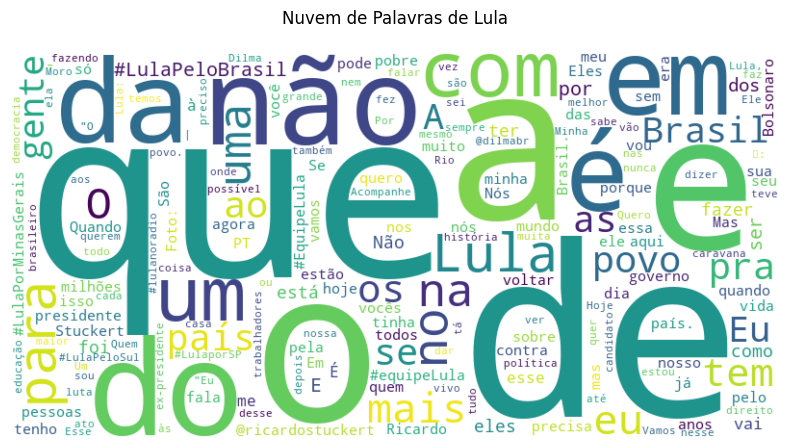

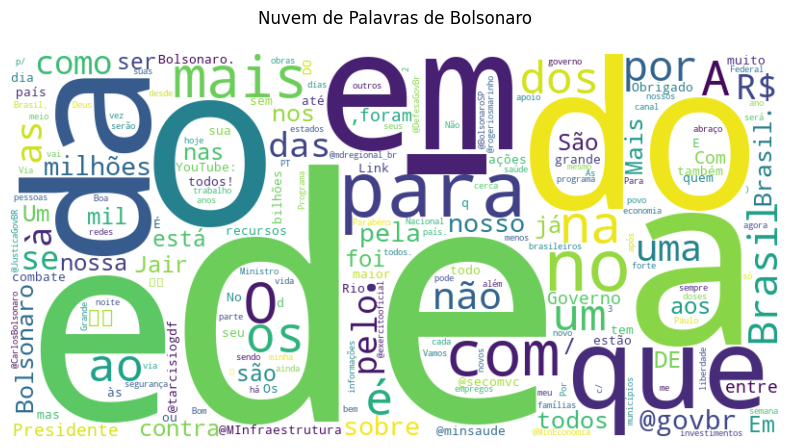

In [89]:
generate_wordcloud_from_df_column(lula_df, 'tweet', 'Lula')
generate_wordcloud_from_df_column(bolsonaro_df, 'tweet', 'Bolsonaro')

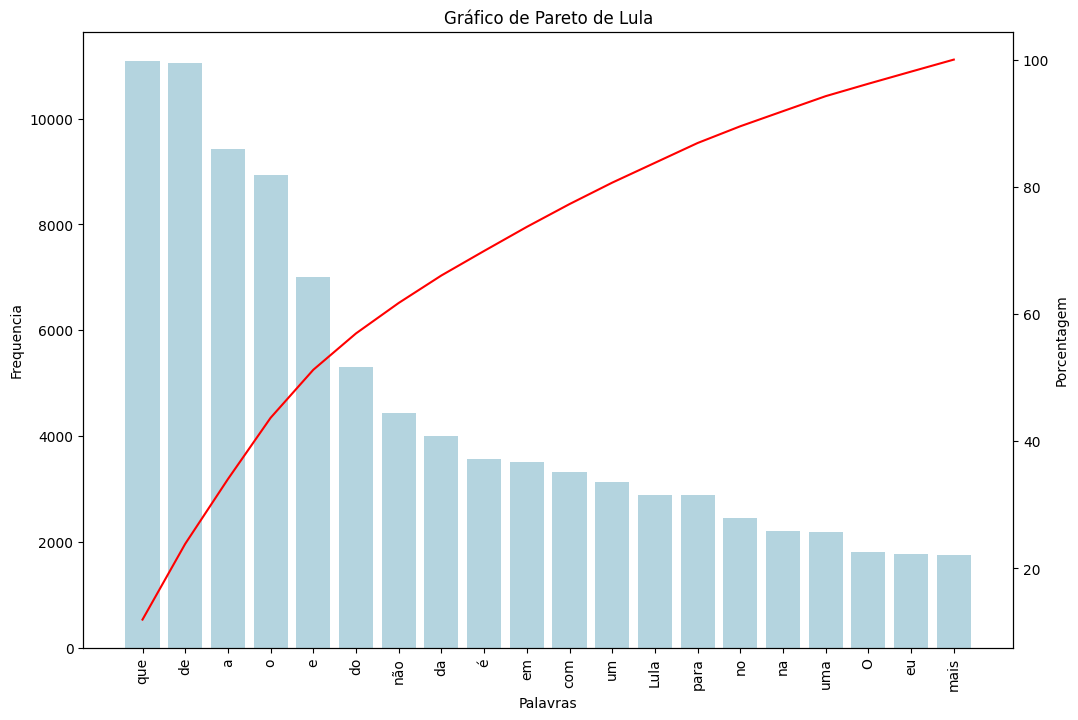

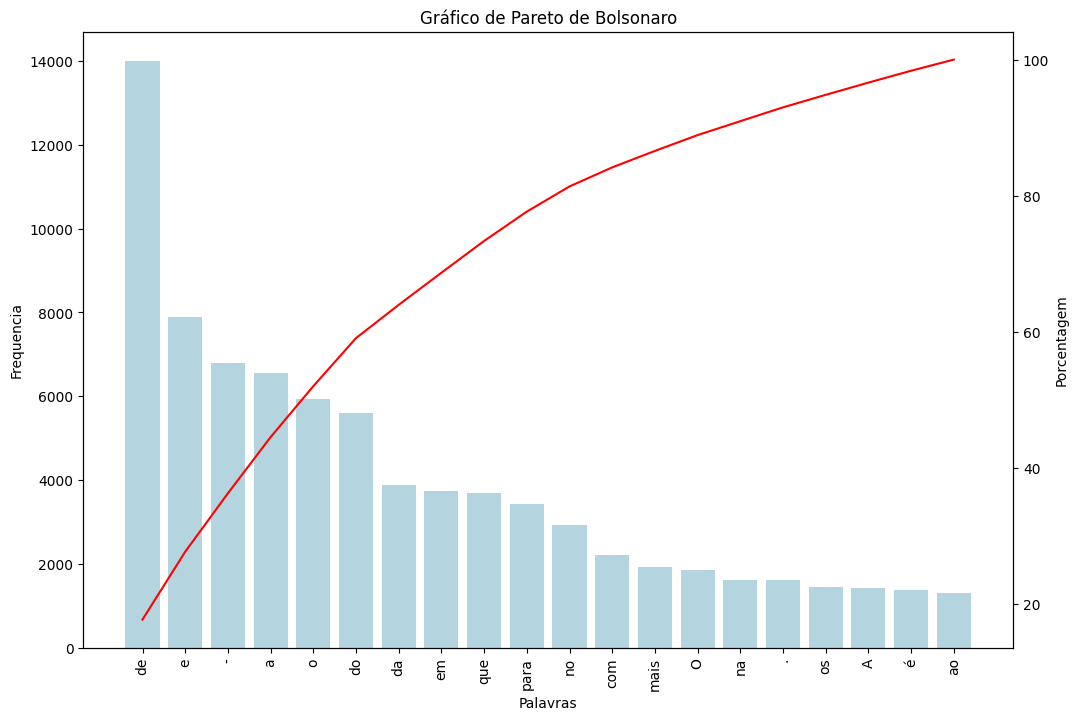

In [90]:
graf_pareto(lula_df, "tweet", 20, 'Lula')
graf_pareto(bolsonaro_df, "tweet", 20, 'Bolsonaro')

In [91]:
lula_df['tweet']

0        O Brasil piorou. A nova pesquisa do boletim De...
1        Nós estamos disputando com alguém que prometeu...
2        As mentiras contra Lula já aconteciam antes me...
3        Aprendi com minha mãe a não desistir. Quando v...
4        "Um dos meus sonhos é um dia estudar medicina....
                               ...                        
15135    "Os trabalhadores estão com @dilmabr ",  diz o...
15136    @dilmabr e Lula saem agora pelas ruas de São B...
15137    Lula visita o @smabc e cumprimenta sindicalist...
15138    Acompanhe notícias da caminhada também pelo @p...
15139    Lula acaba de chegar ao @smabc de onde começar...
Name: tweet, Length: 15140, dtype: object

### Limpeza

Nessa etapa, removeu-se as *stop words*, sendo elas o conjunto pre-setado do corpus do nltk, à exceção de palavras na negativa (que poderiam agregar valor no processamento). Além disso, excluiu-se palavras comuns e sem valor que forma observadas nos tuítes e que escapavam às *stop words*. Excluiu-se também a pontuação e tipos de texto muito utilizados em tuítes: *hashtags*, *cashtags*, *links* e afins. Essas últimas exclusões foram feitas utilizando Regex. Por fim, gerou-se as mesmas visualizações de antes, a fim de destacar as diferenças.

In [256]:
def regex_remove_accents(word):
    """
    Removes common accent characters, lower form.
    Uses: regex.
    Author: https://stackoverflow.com/users/4725707/rigonz

    *w/ small changes for applicability*
    """
    word = re.sub(r'[àáâãäå]', 'a', word)
    word = re.sub(r'[èéêë]', 'e', word)
    word = re.sub(r'[ìíîï]', 'i', word)
    word = re.sub(r'[òóôõö]', 'o', word)
    word = re.sub(r'[ùúûü]', 'u', word)
    word = re.sub(r'[ç]', 'c', word) # addition for this case
    return word

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
                               u"\U0001F680-\U0001F6FF"  # transportes y símbolos mapas
                               u"\U0001F700-\U0001F77F"  # símbolos alquimia
                               u"\U0001F780-\U0001F7FF"  # símbolos marcapáginas
                               u"\U0001F800-\U0001F8FF"  # símbolos y pictogramas suplemento
                               u"\U0001F900-\U0001F9FF"  # emojis diversos
                               u"\U0001FA00-\U0001FA6F"  # emojis adicionales
                               u"\U0001FA70-\U0001FAFF"  # símbolos de juego de cartas
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def regex_filter(texto:str)->str:
    """
    Removes unhelpful types of caracteres or  of string of caracteres, such as
    links, hash e cashtags, mentions, multiple spaces, numbers (here, it wont be useful),
    repeated caracteres and special caracteres.
    Uses: regex.
    Author: Larissa Kelmer
    """
    tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', texto) #removal of links
    tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet) #remove cashtags
    tweet = re.sub('\#[a-zA-Z0-9]*', ' ', tweet) #remove hastags
    tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet) #remove menções
    tweet = re.sub(r'(\W)\1+', r'\1', tweet) #remove repeated caracteres
    #tweet = re.sub(r'\b\d+(?:\.\d+)?\s+', ' ', tweet) #remove multiples numbers
    #tweet = re.sub(r'(.)\1+', r'\1\1', tweet) #remove repeated caracteres
    tweet = re.sub(r'_', ' ', tweet) #remove underscore
    tweet = re.sub(r'\b[b-df-hj-np-tv-z]\b', '', tweet) #Remove consoantes solitárias
    tweet = re.sub(r'\b\d+\b', '', tweet) # Remove números
    tweet = re.sub(r'\b\.\b', '', tweet)
    tweet = re.sub(r'\b[àáâãäåèéêëìíîïòóôõöùúûü]\b', '', tweet)
    tweet = tweet.strip(string.punctuation) #separating punctuation from words
    tweet = re.sub(r'\t', '', tweet) #remove tab
    tweet = re.sub(r'\s+', ' ', tweet)#remove extra blank spaces

    return tweet

In [257]:
stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words = ([sw.lower() for sw in stop_words if (sw!='não' and sw!='nem')])
print('Stop words: ', stop_words)

#adicionando pontuação nas pontuações a serem removidas
pontuacao = ['),', '",','...','/']
for ponto in punctuation:
  pontuacao.append(ponto)
print('Pontuação: ', punctuation)

#adicionando algumas palavras dos tuítes que não contribuem
extra = ['_br', 'vídeo', 'vai', 'foto', 'Eu', 'a', 'pra', 'Ricardo', 'stuckert'
         'O', '\n', 'então', 'youtube','toda','todo','todas','todos','tambem',
         'ate','sobr','_br', 'aqui', 'fazer', 'casa', 'agora', 'ter', 'sobre',
         'coisa', 'ele', 'precisa', 'preciso', 'hoje', 'quer', 'voce', 'porque', 
         'já', 'lá', 'ao vivo', 'quero', 'pode', 'eu', 'desde', 'via', 'após', 'via',
         'ao', 'vivo', 'r', '   ']
extra = ([word.lower() for word in extra])

stop_words = pontuacao + extra + stop_words
#stop_words = set([regex_remove_accents(texto) for texto in stop_words])
#stop_words_sem_acento = [unidecode.unidecode(texto) for texto in stop_words_final]
print(stop_words)


def remove_stopwords(texto:str)->str:
    if isinstance(texto, str):
        texto = remove_emojis(texto)
        tokens = tokenize.WhitespaceTokenizer().tokenize(texto.lower())
        tokens_sem_stopwords = [regex_filter(word) for word in tokens if word.lower() not in stop_words]
        texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
        return texto_sem_stopwords
    else:
        return texto

Stop words:  ['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvesse

In [258]:
lula_df['tweet'] = lula_df['tweet'].str.lower()
bolsonaro_df['tweet'] = bolsonaro_df['tweet'].str.lower()

lula_df = lula_df.applymap(str)
bolsonaro_df = bolsonaro_df.applymap(str)

lula_df["tratamento_1"] = lula_df["tweet"].apply(remove_stopwords)
bolsonaro_df["tratamento_1"] = bolsonaro_df["tweet"].apply(remove_stopwords)

In [259]:
lula_df['tratamento_1'].replace('', np.nan, inplace=True)
lula_df.dropna(subset=['tratamento_1'], inplace=True)

bolsonaro_df['tratamento_1'].replace('', np.nan, inplace=True)
bolsonaro_df.dropna(subset=['tratamento_1'], inplace=True)

In [260]:
lula_df[['tweet', 'tratamento_1']].head(5)

tweet  \
0                                     o brasil piorou. a nova pesquisa do boletim desigualdades nas metrópoles mostra o que já vemos pelas ruas: aumento da miséria, fome e famílias sem um teto pra viver. resultado de um governo que foi irresponsável por quatro anos e agora quer fingir trabalhar. #equipelula   
1                                           nós estamos disputando com alguém que prometeu gerar empregos com uma carteira de trabalho verde e amarela, mas eu quero saber quem é que está trabalhando com a tal da carteira. acabaram com a carteira de trabalho e tiraram o direito dos trabalhadores brasileiros.   
2                as mentiras contra lula já aconteciam antes mesmo de existir o nome fake news. túnel escondido de são bernardo para o morumbi, mansão no guarujá… mesmo com tantas mentiras, lula sempre provou que é inocente. espalhe @verdadenarede. #equipelula https://t.co/iewoqijwvb https://t.co/m98oxdxis9   
3                                                                                                       aprendi com minha mãe a não desistir. quando vocês estiverem desanimados, lembrem de mim. levantem a cabeça e peçam disposição, porque quem não tem disposição não ganha nada. bom dia e boa semana pra nós.   
4  "um dos meus sonhos é um dia estudar medicina. sei que tenho que estudar muito para ser aprovado no enem ou etc. graças a você, filho de pobre tem chance de entrar em uma universidade. lula você é esperança!" - yuri, de guaribas, piauí, 13 anos ❤️#equipelula\n\n🎥: @ricardostuckert https://t.co/sddrxoo52w   

                                                                                                                                                                             tratamento_1  
0  brasil piorou nova pesquisa boletim desigualdades metrópoles mostra vemos ruas aumento miséria fome famílias teto viver resultado governo irresponsável quatro anos fingir trabalhar    
1           disputando alguém prometeu gerar empregos carteira trabalho verde amarela saber trabalhando tal carteira acabaram carteira trabalho tiraram direito trabalhadores brasileiros  
2               mentiras contra lula aconteciam antes existir nome fake news túnel escondido bernardo morumbi mansão guarujá… tantas mentiras lula sempre provou inocente espalhe          
3                                                  aprendi mãe não desistir desanimados lembrem mim levantem cabeça peçam disposição não disposição não ganha nada bom dia boa semana nós  
4                          um sonhos dia estudar medicina sei estudar aprovado enem etc graças você filho pobre chance entrar universidade lula esperança yuri guaribas piauí  anos

In [261]:
bolsonaro_df[['tweet', 'tratamento_1']].head(5)

tweet  \
0                                                                                                                                                                  acompanhe, no horário, ao vivo, pelo canal do flow podcast: https://t.co/eztlteqveu https://t.co/mmhjnptc7m   
1                                                                                                                                                   - entre os planos aplicados pela atual gestão também está a carteira de desestatização classificada como a maior do mundo.   
2                                               - recentemente priorizando o saneamento básico e infraestrutura, o bndes anunciou também pareceria com o sebrae para criar um fundo garantidor voltado para empreendedores individuais, além de micros e pequenos empresários.   
3  - longe do pt,  bndes que patrocinava obras em ditaduras socialistas deixando de fora investimentos no 🇧🇷 além de outras movimentações sombrias, hoje o órgão recebeu a premiação de “transformação bancária” da américa latina do euromoney awards for excellence em 2022.   
4                  - também, a ampliação do teto do financiamento para o curso de medicina foi aumentado em mais de 20%, em 2022, sendo mais uma novidade aos estudantes da área de saúde.\n \n- implemento de 22,8% passando do atual valor, r$ 42.983,70, para r$ 52.805,66.   

                                                                                                                                                                                                    tratamento_1  
0                                                                                                                                                                  acompanhe horário vivo canal flow podcast      
1                                                                                                                                 planos aplicados atual gestão carteira desestatização classificada maior mundo  
2                           recentemente priorizando saneamento básico infraestrutura bndes anunciou pareceria sebrae criar fundo garantidor voltado empreendedores individuais além micros pequenos empresários  
3  longe pt bndes patrocinava obras ditaduras socialistas deixando investimentos além outras movimentações sombrias órgão recebeu premiação “transformação bancária” américa latina euromoney awards excellence   
4                                                                     também ampliação teto financiamento curso medicina aumentado   sendo novidade estudantes área saúde implemento  passando atual valor

In [262]:
lula_df['tratamento_1'][10]

' chegaram facebook acompanha lula lá vem curtir compartilhar ajudar conteúdo chegar longe      '

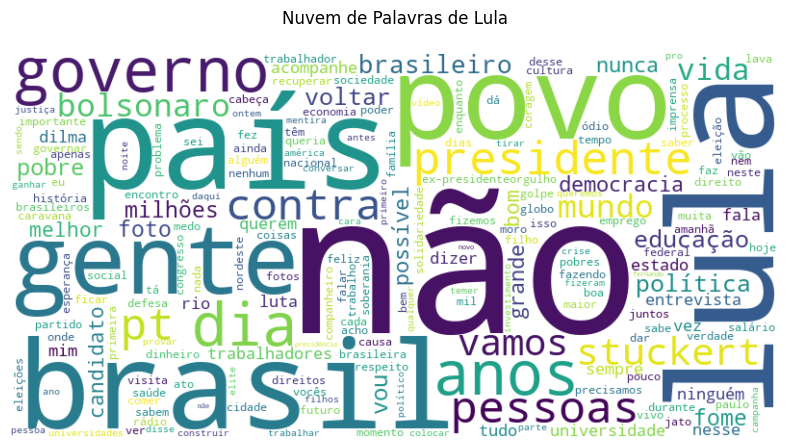

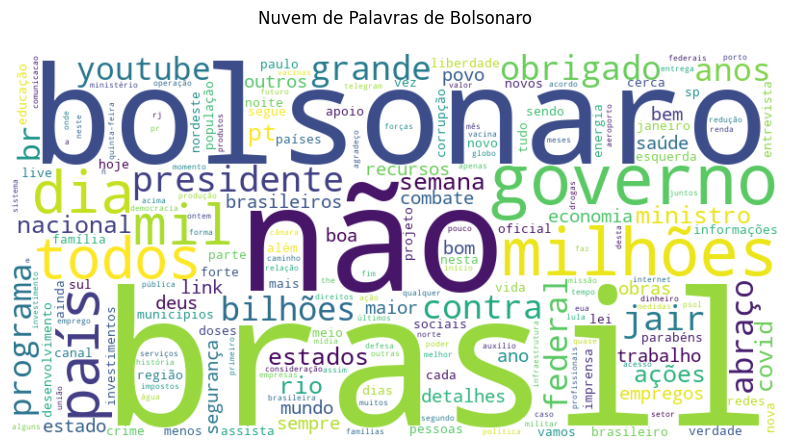

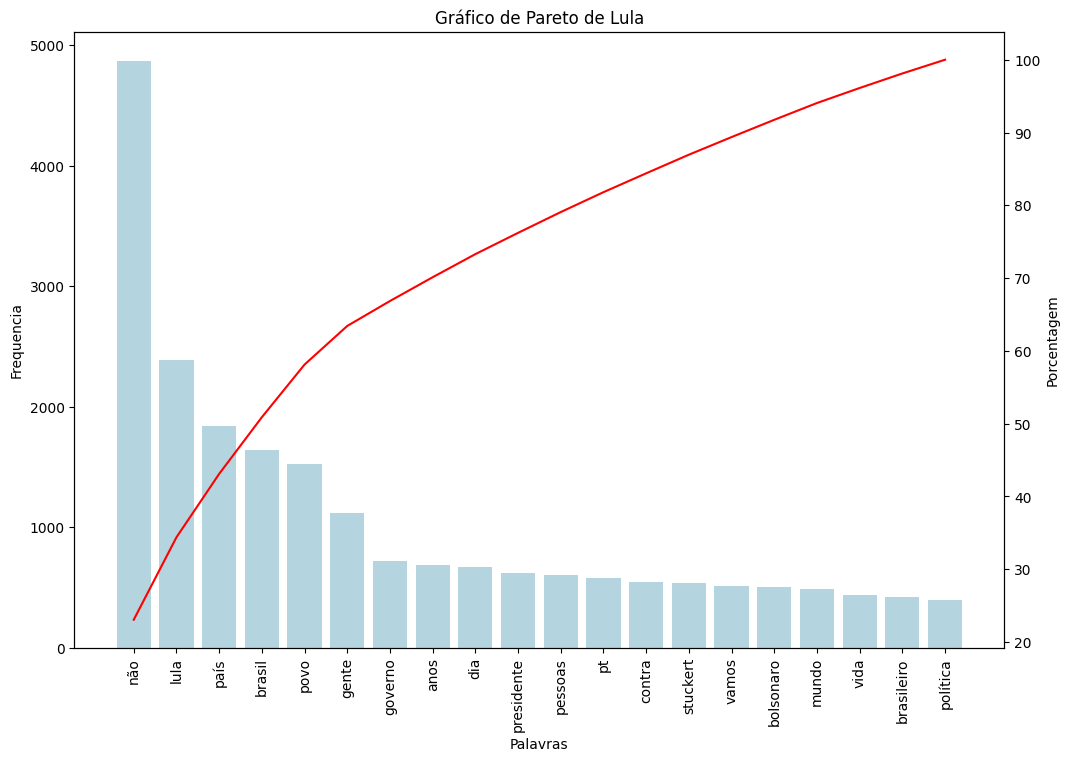

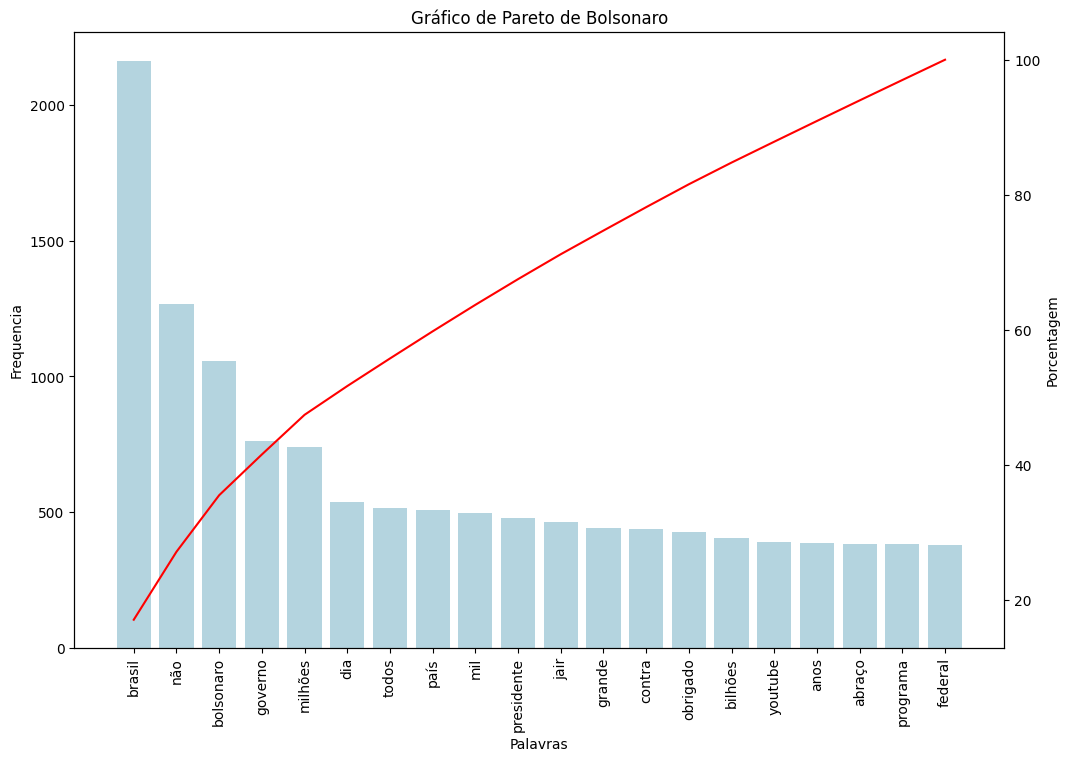

In [263]:
generate_wordcloud_from_df_column(lula_df, 'tratamento_1', 'Lula')
generate_wordcloud_from_df_column(bolsonaro_df, 'tratamento_1', 'Bolsonaro')

graf_pareto(lula_df, "tratamento_1", 20, 'Lula')
graf_pareto(bolsonaro_df, "tratamento_1", 20, 'Bolsonaro')

### Tokenização

 A tokenização é o processo de dividir um texto em unidades menores chamadas tokens. Estes tokens podem ser palavras individuais, subpalavras, caracteres ou até mesmo frases completas, dependendo do objetivo da análise. A tokenização é uma etapa fundamental no pré-processamento de dados em PLN, pois ajuda a transformar o texto em uma forma que possa ser facilmente manipulada e processada por algoritmos de aprendizado de máquina. Essa técnica é crucial em várias tarefas de PLN, como análise de sentimentos, tradução automática, reconhecimento de entidades nomeadas e muito mais, pois fornece a base para a análise textual.

In [272]:
def tokenize_tweet(tweet):
    tokens = re.findall(r"[\w']+", tweet.lower())
    return tokens

bolsonaro_df['tokens'] = bolsonaro_df['tweet'].apply(tokenize_tweet)
lula_df['tokens'] = lula_df['tweet'].apply(tokenize_tweet)

In [273]:
bolsonaro_df[['tweet', 'tokens']].head()

tweet  \
0                                                                                                                                                                  acompanhe, no horário, ao vivo, pelo canal do flow podcast: https://t.co/eztlteqveu https://t.co/mmhjnptc7m   
1                                                                                                                                                   - entre os planos aplicados pela atual gestão também está a carteira de desestatização classificada como a maior do mundo.   
2                                               - recentemente priorizando o saneamento básico e infraestrutura, o bndes anunciou também pareceria com o sebrae para criar um fundo garantidor voltado para empreendedores individuais, além de micros e pequenos empresários.   
3  - longe do pt,  bndes que patrocinava obras em ditaduras socialistas deixando de fora investimentos no 🇧🇷 além de outras movimentações sombrias, hoje o órgão recebeu a premiação de “transformação bancária” da américa latina do euromoney awards for excellence em 2022.   
4                  - também, a ampliação do teto do financiamento para o curso de medicina foi aumentado em mais de 20%, em 2022, sendo mais uma novidade aos estudantes da área de saúde.\n \n- implemento de 22,8% passando do atual valor, r$ 42.983,70, para r$ 52.805,66.   

                                                                                                                                                                                                                                                                                                     tokens  
0                                                                                                                                                                                    [acompanhe, no, horário, ao, vivo, pelo, canal, do, flow, podcast, https, t, co, eztlteqveu, https, t, co, mmhjnptc7m]  
1                                                                                                                                                               [entre, os, planos, aplicados, pela, atual, gestão, também, está, a, carteira, de, desestatização, classificada, como, a, maior, do, mundo]  
2                                                  [recentemente, priorizando, o, saneamento, básico, e, infraestrutura, o, bndes, anunciou, também, pareceria, com, o, sebrae, para, criar, um, fundo, garantidor, voltado, para, empreendedores, individuais, além, de, micros, e, pequenos, empresários]  
3  [longe, do, pt, bndes, que, patrocinava, obras, em, ditaduras, socialistas, deixando, de, fora, investimentos, no, além, de, outras, movimentações, sombrias, hoje, o, órgão, recebeu, a, premiação, de, transformação, bancária, da, américa, latina, do, euromoney, awards, for, excellence, em, 2022]  
4                  [também, a, ampliação, do, teto, do, financiamento, para, o, curso, de, medicina, foi, aumentado, em, mais, de, 20, em, 2022, sendo, mais, uma, novidade, aos, estudantes, da, área, de, saúde, implemento, de, 22, 8, passando, do, atual, valor, r, 42, 983, 70, para, r, 52, 805, 66]

In [274]:
lula_df[['tweet', 'tokens']].head()

tweet  \
0                                     o brasil piorou. a nova pesquisa do boletim desigualdades nas metrópoles mostra o que já vemos pelas ruas: aumento da miséria, fome e famílias sem um teto pra viver. resultado de um governo que foi irresponsável por quatro anos e agora quer fingir trabalhar. #equipelula   
1                                           nós estamos disputando com alguém que prometeu gerar empregos com uma carteira de trabalho verde e amarela, mas eu quero saber quem é que está trabalhando com a tal da carteira. acabaram com a carteira de trabalho e tiraram o direito dos trabalhadores brasileiros.   
2                as mentiras contra lula já aconteciam antes mesmo de existir o nome fake news. túnel escondido de são bernardo para o morumbi, mansão no guarujá… mesmo com tantas mentiras, lula sempre provou que é inocente. espalhe @verdadenarede. #equipelula https://t.co/iewoqijwvb https://t.co/m98oxdxis9   
3                                                                                                       aprendi com minha mãe a não desistir. quando vocês estiverem desanimados, lembrem de mim. levantem a cabeça e peçam disposição, porque quem não tem disposição não ganha nada. bom dia e boa semana pra nós.   
4  "um dos meus sonhos é um dia estudar medicina. sei que tenho que estudar muito para ser aprovado no enem ou etc. graças a você, filho de pobre tem chance de entrar em uma universidade. lula você é esperança!" - yuri, de guaribas, piauí, 13 anos ❤️#equipelula\n\n🎥: @ricardostuckert https://t.co/sddrxoo52w   

                                                                                                                                                                                                                                                                                                                                          tokens  
0                         [o, brasil, piorou, a, nova, pesquisa, do, boletim, desigualdades, nas, metrópoles, mostra, o, que, já, vemos, pelas, ruas, aumento, da, miséria, fome, e, famílias, sem, um, teto, pra, viver, resultado, de, um, governo, que, foi, irresponsável, por, quatro, anos, e, agora, quer, fingir, trabalhar, equipelula]  
1                             [nós, estamos, disputando, com, alguém, que, prometeu, gerar, empregos, com, uma, carteira, de, trabalho, verde, e, amarela, mas, eu, quero, saber, quem, é, que, está, trabalhando, com, a, tal, da, carteira, acabaram, com, a, carteira, de, trabalho, e, tiraram, o, direito, dos, trabalhadores, brasileiros]  
2         [as, mentiras, contra, lula, já, aconteciam, antes, mesmo, de, existir, o, nome, fake, news, túnel, escondido, de, são, bernardo, para, o, morumbi, mansão, no, guarujá, mesmo, com, tantas, mentiras, lula, sempre, provou, que, é, inocente, espalhe, verdadenarede, equipelula, https, t, co, iewoqijwvb, https, t, co, m98oxdxis9]  
3                                                                                                     [aprendi, com, minha, mãe, a, não, desistir, quando, vocês, estiverem, desanimados, lembrem, de, mim, levantem, a, cabeça, e, peçam, disposição, porque, quem, não, tem, disposição, não, ganha, nada, bom, dia, e, boa, semana, pra, nós]  
4  [um, dos, meus, sonhos, é, um, dia, estudar, medicina, sei, que, tenho, que, estudar, muito, para, ser, aprovado, no, enem, ou, etc, graças, a, você, filho, de, pobre, tem, chance, de, entrar, em, uma, universidade, lula, você, é, esperança, yuri, de, guaribas, piauí, 13, anos, equipelula, ricardostuckert, https, t, co, sddrxoo52w]

In [277]:
bolsonaro_df['tokens'] = bolsonaro_df['tratamento_1'].apply(tokenize_tweet)
bolsonaro_df['tokens']

0                                                                                                                                                                                          [acompanhe, horário, vivo, canal, flow, podcast]
1                                                                                                                                                  [planos, aplicados, atual, gestão, carteira, desestatização, classificada, maior, mundo]
2                                  [recentemente, priorizando, saneamento, básico, infraestrutura, bndes, anunciou, pareceria, sebrae, criar, fundo, garantidor, voltado, empreendedores, individuais, além, micros, pequenos, empresários]
3        [longe, pt, bndes, patrocinava, obras, ditaduras, socialistas, deixando, investimentos, além, outras, movimentações, sombrias, órgão, recebeu, premiação, transformação, bancária, américa, latina, euromoney, awards, excellence]
4                                                       

In [278]:
lula_df['tokens'] = lula_df['tratamento_1'].apply(tokenize_tweet)

In [ ]:
lula_df['tweet'] = lula_df['tweet'].str.lower()
bolsonaro_df['tweet'] = bolsonaro_df['tweet'].str.lower()

lula_df = lula_df.applymap(str)
bolsonaro_df = bolsonaro_df.applymap(str)

lula_df["tratamento_1"] = lula_df["tweet"].apply(remove_stopwords)
bolsonaro_df["tratamento_1"] = bolsonaro_df["tweet"].apply(remove_stopwords)

#### N-grams

N-grams são sequências de n itens consecutivos, geralmente palavras, em um texto. Eles capturam informações sobre a estrutura e o contexto do texto, sendo úteis em tarefas de PLN como modelagem de linguagem e extração de características. Ao analisar sequências de palavras, os n-grams ajudam a compreender o contexto e a extrair informações relevantes dos dados textuais.

In [282]:
# Extrair bigramas e trigramas para Bolsonaro
bolsonaro_df['bigrams'] = bolsonaro_df['tokens'].apply(lambda x: list(nltk.bigrams(x)))
bolsonaro_df['trigrams'] = bolsonaro_df['tokens'].apply(lambda x: list(nltk.ngrams(x, 3)))

# Extrair bigramas e trigramas para Lula
lula_df['bigrams'] = lula_df['tokens'].apply(lambda x: list(nltk.bigrams(x)))
lula_df['trigrams'] = lula_df['tokens'].apply(lambda x: list(nltk.ngrams(x, 3)))

# Visualizar os resultados
bolsonaro_df[['tokens', 'bigrams', 'trigrams']].head()
lula_df[['tokens', 'bigrams', 'trigrams']].head()

tokens  \
0  [brasil, piorou, nova, pesquisa, boletim, desigualdades, metrópoles, mostra, vemos, ruas, aumento, miséria, fome, famílias, teto, viver, resultado, governo, irresponsável, quatro, anos, fingir, trabalhar]   
1            [disputando, alguém, prometeu, gerar, empregos, carteira, trabalho, verde, amarela, saber, trabalhando, tal, carteira, acabaram, carteira, trabalho, tiraram, direito, trabalhadores, brasileiros]   
2                       [mentiras, contra, lula, aconteciam, antes, existir, nome, fake, news, túnel, escondido, bernardo, morumbi, mansão, guarujá, tantas, mentiras, lula, sempre, provou, inocente, espalhe]   
3                                                  [aprendi, mãe, não, desistir, desanimados, lembrem, mim, levantem, cabeça, peçam, disposição, não, disposição, não, ganha, nada, bom, dia, boa, semana, nós]   
4                               [um, sonhos, dia, estudar, medicina, sei, estudar, aprovado, enem, etc, graças, você, filho, pobre, chance, entrar, universidade, lula, esperança, yuri, guaribas, piauí, anos]   

                                                                                                                                                                                                                                                                                                                                                                                                                                             bigrams  \
0  [(brasil, piorou), (piorou, nova), (nova, pesquisa), (pesquisa, boletim), (boletim, desigualdades), (desigualdades, metrópoles), (metrópoles, mostra), (mostra, vemos), (vemos, ruas), (ruas, aumento), (aumento, miséria), (miséria, fome), (fome, famílias), (famílias, teto), (teto, viver), (viver, resultado), (resultado, governo), (governo, irresponsável), (irresponsável, quatro), (quatro, anos), (anos, fingir), (fingir, trabalhar)]   
1                                  [(disputando, alguém), (alguém, prometeu), (prometeu, gerar), (gerar, empregos), (empregos, carteira), (carteira, trabalho), (trabalho, verde), (verde, amarela), (amarela, saber), (saber, trabalhando), (trabalhando, tal), (tal, carteira), (carteira, acabaram), (acabaram, carteira), (carteira, trabalho), (trabalho, tiraram), (tiraram, direito), (direito, trabalhadores), (trabalhadores, brasileiros)]   
2                                              [(mentiras, contra), (contra, lula), (lula, aconteciam), (aconteciam, antes), (antes, existir), (existir, nome), (nome, fake), (fake, news), (news, túnel), (túnel, escondido), (escondido, bernardo), (bernardo, morumbi), (morumbi, mansão), (mansão, guarujá), (guarujá, tantas), (tantas, mentiras), (mentiras, lula), (lula, sempre), (sempre, provou), (provou, inocente), (inocente, espalhe)]   
3                                                                                                 [(aprendi, mãe), (mãe, não), (não, desistir), (desistir, desanimados), (desanimados, lembrem), (lembrem, mim), (mim, levantem), (levantem, cabeça), (cabeça, peçam), (peçam, disposição), (disposição, não), (não, disposição), (disposição, não), (não, ganha), (ganha, nada), (nada, bom), (bom, dia), (dia, boa), (boa, semana), (semana, nós)]   
4                                                   [(um, sonhos), (sonhos, dia), (dia, estudar), (estudar, medicina), (medicina, sei), (sei, estudar), (estudar, aprovado), (aprovado, enem), (enem, etc), (etc, graças), (graças, você), (você, filho), (filho, pobre), (pobre, chance), (chance, entrar), (entrar, universidade), (universidade, lula), (lula, esperança), (esperança, yuri), (yuri, guaribas), (guaribas, piauí), (piauí, anos)]   

                                                                                                                                                                                                                                                                                                     

In [292]:
def graf_pareto_n_grams(texto, coluna_texto, quantidade, nome):

    todos_ngramas = [' '.join(ngram) for ngrams_list in texto[coluna_texto] for ngram in ngrams_list]

    # Calcular as frequências dos n-gramas
    frequencias = nltk.FreqDist(todos_ngramas)

    # Criar um DataFrame com as frequências dos n-gramas
    df_frequencias = pd.DataFrame({'N-gramas': frequencias.keys(),
                                   'Frequência': frequencias.values()})

    # Selecionar os n-gramas mais frequentes
    df_frequencias = df_frequencias.nlargest(n=quantidade, columns='Frequência')

    # Calcular a porcentagem acumulada
    total = df_frequencias['Frequência'].sum()
    df_frequencias['Porcentagem'] = (df_frequencias['Frequência'].cumsum() / total) * 100

    # Plotar o gráfico de Pareto
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_frequencias, x='N-gramas', y='Frequência', color='lightblue')
    ax2 = ax.twinx()
    sns.lineplot(data=df_frequencias, x='N-gramas', y='Porcentagem', color='red', sort=False, ax=ax2)
    plt.title('Gráfico de Pareto de ' + nome)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

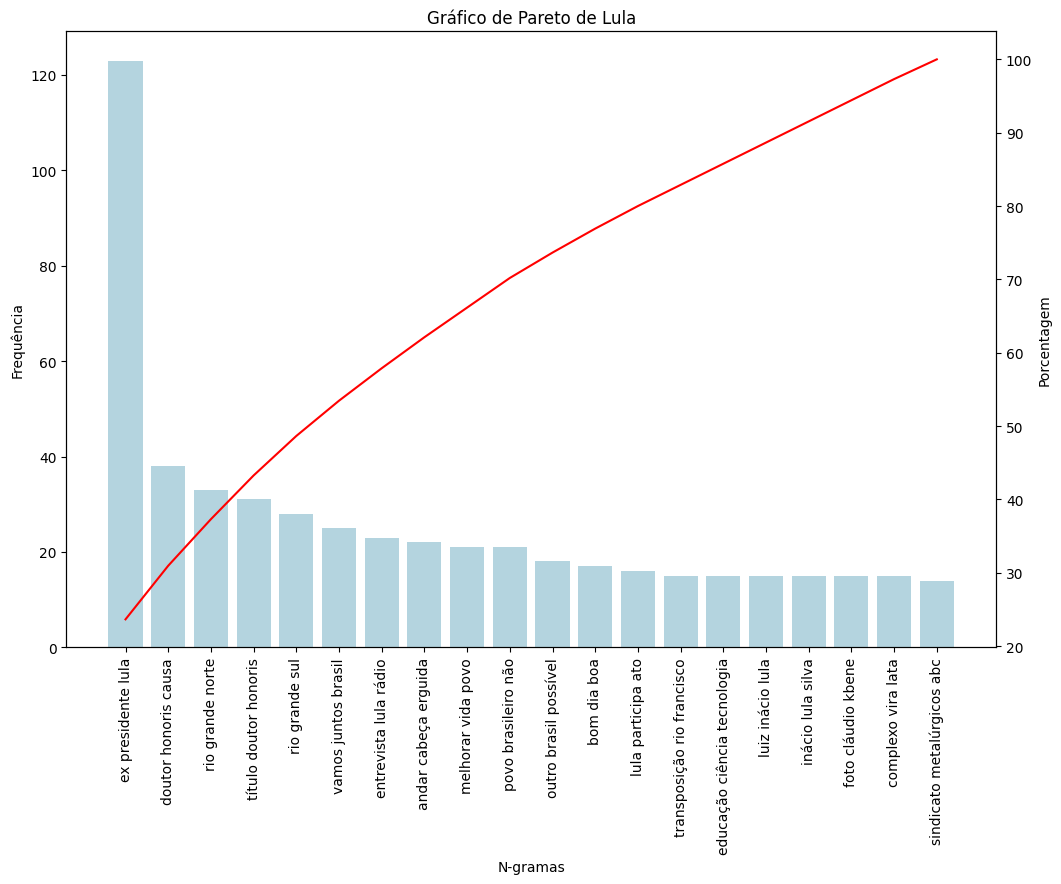

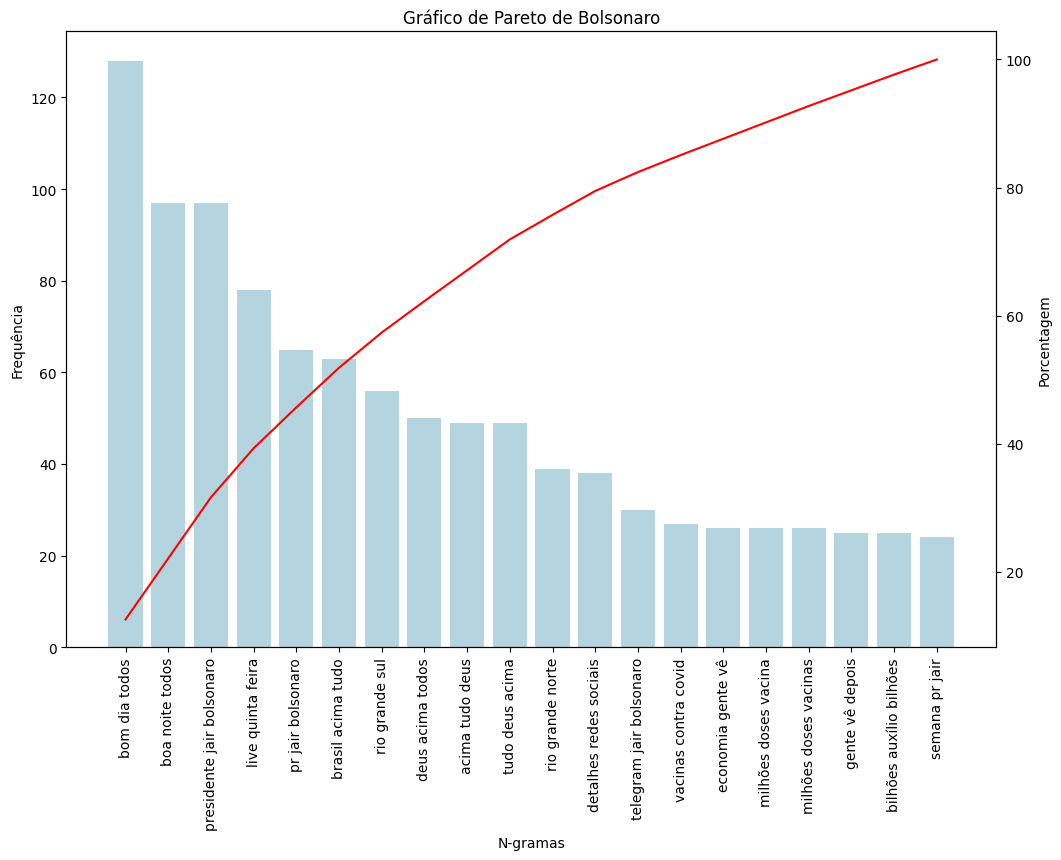

In [293]:
graf_pareto_n_grams(lula_df, 'trigrams', 20, 'Lula')
graf_pareto_n_grams(bolsonaro_df, 'trigrams', 20, 'Bolsonaro')

### Feature Extraction

Feature extraction é o processo de transformar dados em representações numéricas que capturam informações de maior relevância. Ele permite processar e tirar *insights* de modelos complexos.

#### Embeddings

Embeddings são representações vetoriais de palavras e permitem a transformação dessas palavras para formatos numéricos que capturam a semântica do texto. O Spacy usa uma CNN para esse cálculo por *default*. É de interesse usar o BERT numa próxima etapa. 

In [294]:
def generate_embeddings(tokens):
    embeddings = []
    for token in tokens:
        embedding = nlp(token).vector
        embeddings.append(embedding)
    return embeddings

lula_df["embeddings_uni"] = lula_df['tokens'].apply(lambda x: generate_embeddings(x))
bolsonaro_df["embeddings_uni"] = bolsonaro_df['tokens'].apply(lambda x: generate_embeddings(x))

In [295]:
lula_df["embeddings_uni"]

0              [[0.94597495, -1.4509016, -0.7242687, -2.5647259, 1.6869419, -4.6141977, -0.25251797, -1.3752345, -5.2429066, -0.026394606, 1.4919624, -3.007764, -3.0420983, 0.5825694, -1.3168366, 1.8034259, 8.100355, 2.8696377, -3.8086133, -0.16515902, -0.57154626, 0.046026647, -3.233074, -2.4109745, 2.409361, 0.85668576, 1.7981569, -1.5379915, 2.404906, -3.0185142, 5.155394, -1.1705754, -2.0493333, 1.7879345, 3.9366999, 2.477941, -3.6461577, 6.102936, -1.288666, 1.1050164, -3.0956204, -3.786377, -3.7822561, -2.9995127, -2.6431947, -3.3033419, -2.6022453, -0.116508305, 0.6607145, 0.6449104, -4.1910353, 0.63138604, -1.65208, 3.9032502, -1.1970754, 1.0111655, 3.643776, -4.7509503, -3.0533512, 4.0299306, -3.7594702, 6.136184, -1.7213638, -0.58831465, 0.74594545, -2.136914, -1.8694478, 5.0960784, -3.7284198, 2.3691633, 0.76465213, -0.03270054, 6.9174795, 0.18335101, -0.68457454, 6.0676246, -0.9809929, 8.259279, -1.6937317, -1.5724638, -1.706291, 0.053837597, 2.3204384, 2.900614, -3.6790578

In [296]:
bolsonaro_df["embeddings_uni"]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
def get_bigram_embeddings(bigrams):
    embeddings = []
    for bigram in bigrams:
        if isinstance(bigram, tuple):
            bigram_str = ' '.join(bigram)
            tokens = nlp(bigram_str)
            if len(tokens) == 2:
                embedding = np.mean([token.vector for token in tokens], axis=0)
                embeddings.append(embedding)
    return embeddings


lula_df["embeddings"] = lula_df['bigrams'].apply(lambda x: get_bigram_embeddings(x))
bolsonaro_df["embeddings"] = bolsonaro_df['bigrams'].apply(lambda x: get_bigram_embeddings(x))

In [287]:
lula_df["embeddings"]

0                              [[-0.9532685, 1.8346896, -1.6068605, -1.5928378, -2.0871203, -1.9175644, 0.8824487, 0.527623, -1.507092, -0.1747185, 3.1382926, -1.5302312, -3.5262408, -0.46770692, -2.9872427, 0.15003407, 4.0942006, 5.151145, -2.116745, -1.7274919, -2.8302608, -1.2060572, -1.0191576, 1.2832198, -0.61039186, 0.9421127, 2.7422476, 1.5352337, 0.91025263, 1.964893, -1.476445, 0.009442225, -0.6001667, -0.61754096, 1.7491933, 1.1512958, -4.451543, 0.83882785, -2.4633017, -0.5958812, 1.1428708, -1.6415503, -1.1153834, -1.1737335, -0.5477996, -3.5181448, 1.0111573, 0.15958956, -1.5286623, -1.0707352, -1.626778, -0.7270168, 0.7998677, 2.8176303, 1.5773901, -1.4892603, -0.45971394, -2.3636255, -2.596085, 1.1583316, 0.51423824, 5.1765985, -0.10155791, -1.0217881, 2.1606996, 2.534383, -0.7045529, 4.3148518, -0.45008445, -1.855949, 7.7264695, -1.1892319, 2.6816304, 0.75519216, -0.15984035, 3.8182228, 0.49949622, 3.4371114, -1.542817, -2.284036, -3.1122983, 1.4038908, 3.2042086, -0.44

In [288]:
bolsonaro_df["embeddings"] 

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

#### TF-IDF

O TF-IDF (Term Frequency-Inverse Document Frequency) é uma técnica de feature extraction usada em processamento de texto para avaliar a importância de uma palavra em um documento dentro de um conjunto de documentos. Ele funciona multiplicando a frequência de uma palavra (TF) pelo inverso da frequência do documento (IDF). Isso ajuda a destacar palavras que são frequentes em um documento específico, mas não são comuns em todos os documentos, o que pode ser útil para tarefas como classificação de texto, clustering e recuperação de informação.

In [269]:
tfidf = TfidfVectorizer(lowercase = False, max_features = 1000)

caracteristicas_t1l = tfidf.fit_transform(lula_df['tratamento_1'])
d1_lula = pd.DataFrame(caracteristicas_t1l.todense(), columns = tfidf.get_feature_names_out())
d1_lula

abc  abraço  acaba  acabar  acabou  aceitar  acesso  acha  acham  \
0      0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
1      0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
2      0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
3      0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
4      0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
...    ...     ...    ...     ...     ...      ...     ...   ...    ...   
12293  0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
12294  0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
12295  0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
12296  0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   
12297  0.0     0.0    0.0     0.0     0.0      0.0     0.0   0.0    0.0   

       acharam  ...  áfrica  água  época  íntegra  ódio  ônibus  último  \
0          0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
1          0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
2          0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
3          0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
4          0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
...        ...  ...     ...   ...    ...      ...   ...     ...     ...   
12293      0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
12294      0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
12295      0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
12296      0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   
12297      0.0  ...     0.0   0.0    0.0      0.0   0.0     0.0     0.0   

       últimos  única  único  
0          0.0    0.0    0.0  
1          0.0    0.0    0.0  
2          0.0    0.0    0.0  
3          0.0    0.0    0.0  
4          0.0    0.0    0.0  
...        ...    ...    ...  
12293      0.0    0.0    0.0  
12294      0.0    0.0    0.0  
12295      0.0    0.0    0.0  
12296      0.0    0.0    0.0  
12297      0.0    0.0    0.0  

[12298 rows x 1000 columns]

In [286]:
caracteristicas_t1l = tfidf.fit_transform(bolsonaro_df['tratamento_1'])
d1_bolsonaro = pd.DataFrame(caracteristicas_t1l.todense(), columns = tfidf.get_feature_names_out())


## Extra

##Aplicando Métodos de Análise de Sentimentos

###NaiveBayes

#####LeIA Func

In [ ]:
''' LeIA - Léxico para Inferência Adaptada
https://github.com/rafjaa/LeIA
Este projeto é um fork do léxico e ferramenta para análise de
sentimentos VADER (Valence Aware Dictionary and sEntiment Reasoner)
adaptado para textos em português.
Autor do VADER: C.J. Hutto
Repositório: https://github.com/cjhutto/vaderSentiment
'''

import re
import math
import unicodedata
from itertools import product
import os

PACKAGE_DIRECTORY = '/content/'

# Empirically derived mean sentiment intensity rating increase for booster words
# TODO: Portuguese update
B_INCR = 0.293
B_DECR = -0.293

# Empirically derived mean sentiment intensity rating increase for using ALLCAPs to emphasize a word
# TODO: Portuguese update
C_INCR = 0.733
N_SCALAR = -0.74

# For removing punctuation
REGEX_REMOVE_PUNCTUATION = re.compile('[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))

PUNC_LIST = [
    ".", "!", "?", ",", ";", ":", "-", "'", "\"", "...",
    "—", "–", "!?", "?!", "!!", "!!!", "??", "???", "?!?",
    "!?!", "?!?!", "!?!?"
]

# Negations (Portuguese)
NEGATE = [t.strip() for t in open(
    os.path.join('/content/drive/MyDrive/UFRN/Mestrado/AM/LeIA-master/lexicons/', 'negate.txt')
)]

# Booster/dampener 'intensifiers' or 'degree adverbs' (Portuguese)
boosters = []
for boost in open(os.path.join('/content/drive/MyDrive/UFRN/Mestrado/AM/LeIA-master/lexicons/', 'booster.txt')):
    parts = boost.strip().split(' ')
    boosters.append([' '.join(parts[:-1]), parts[-1]])

BOOSTER_DICT = {}
for t, v in boosters:
    BOOSTER_DICT[t] = B_INCR if v == 'INCR' else B_DECR


# Check for special case idioms containing lexicon words
# TODO: Portuguese
SPECIAL_CASE_IDIOMS = {}


def negated(input_words, include_nt=True):
    """
    Determine if input contains negation words
    """
    input_words = [str(w).lower() for w in input_words]
    neg_words = []
    neg_words.extend(NEGATE)
    for word in neg_words:
        if word in input_words:
            return True
    # if include_nt:
    #     for word in input_words:
    #         if "n't" in word:
    #             return True
    return False


def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score / math.sqrt((score * score) + alpha)
    if norm_score < -1.0:
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score


def allcap_differential(words):
    """
    Check whether just some words in the input are ALL CAPS
    :param list words: The words to inspect
    :returns: `True` if some but not all items in `words` are ALL CAPS
    """
    is_different = False
    allcap_words = 0
    for word in words:
        if word.isupper():
            allcap_words += 1
    cap_differential = len(words) - allcap_words
    if 0 < cap_differential < len(words):
        is_different = True
    return is_different


def scalar_inc_dec(word, valence, is_cap_diff):
    """
    Check if the preceding words increase, decrease, or negate/nullify the
    valence
    """
    scalar = 0.0
    word_lower = word.lower()
    if word_lower in BOOSTER_DICT:
        scalar = BOOSTER_DICT[word_lower]
        if valence < 0:
            scalar *= -1

        # Check if booster/dampener word is in ALLCAPS (while others aren't)
        if word.isupper() and is_cap_diff:
            if valence > 0:
                scalar += C_INCR
            else:
                scalar -= C_INCR
    return scalar


class SentiText(object):
    """
    Identify sentiment-relevant string-level properties of input text.
    """

    def __init__(self, text):
        if not isinstance(text, str):
            text = str(text).encode('utf-8')
        self.text = text
        self.words_and_emoticons = self._words_and_emoticons()

        # Doesn't separate words from adjacent
        # punctuation (keeps emoticons & contractions)
        self.is_cap_diff = allcap_differential(self.words_and_emoticons)


    def _words_plus_punc(self):
        """
        Returns mapping of form:
        {
            'cat,': 'cat',
            ',cat': 'cat',
        }
        """
        no_punc_text = REGEX_REMOVE_PUNCTUATION.sub('', self.text)

        # Removes punctuation (but loses emoticons & contractions)
        words_only = no_punc_text.split()

        # Remove singletons
        words_only = set(w for w in words_only if len(w) > 1)

        # The product gives ('cat', ',') and (',', 'cat')
        punc_before = {''.join(p): p[1] for p in product(PUNC_LIST, words_only)}
        punc_after = {''.join(p): p[0] for p in product(words_only, PUNC_LIST)}
        words_punc_dict = punc_before
        words_punc_dict.update(punc_after)

        return words_punc_dict


    def _words_and_emoticons(self):
        """
        Removes leading and trailing puncutation
        Leaves contractions and most emoticons
            Does not preserve punc-plus-letter emoticons (e.g. :D)
        """
        wes = self.text.split()
        words_punc_dict = self._words_plus_punc()
        wes = [we for we in wes if len(we) > 1]
        for i, we in enumerate(wes):
            if we in words_punc_dict:
                wes[i] = words_punc_dict[we]
        return wes


class SentimentIntensityAnalyzer(object):
    """
    Give a sentiment intensity score to sentences.
    """

    def __init__(
            self,
            lexicon_file=os.path.join('/content/drive/MyDrive/UFRN/Mestrado/AM/LeIA-master/lexicons/',
                'vader_lexicon_ptbr.txt'
            ),
            emoji_lexicon=os.path.join('/content/drive/MyDrive/UFRN/Mestrado/AM/LeIA-master/lexicons/',
                'emoji_utf8_lexicon_ptbr.txt'
            )
    ):
        with open(lexicon_file, encoding='utf-8') as f:
            self.lexicon_full_filepath = f.read()
        self.lexicon = self.make_lex_dict()

        with open(emoji_lexicon, encoding='utf-8') as f:
            self.emoji_full_filepath = f.read()
        self.emojis = self.make_emoji_dict()


    def make_lex_dict(self):
        """
        Convert lexicon file to a dictionary
        """
        lex_dict = {}
        for line in self.lexicon_full_filepath.split('\n'):
            if len(line) < 1:
                continue
            (word, measure) = line.strip().split('\t')[0:2]
            lex_dict[word] = float(measure)
        return lex_dict


    def make_emoji_dict(self):
        """
        Convert emoji lexicon file to a dictionary
        """
        emoji_dict = {}
        for line in self.emoji_full_filepath.split('\n'):
            if len(line) < 1:
                continue
            (emoji, description) = line.strip().split('\t')[0:2]
            emoji_dict[emoji] = description
        return emoji_dict


    def polarity_scores(self, text):
        """
        Return a float for sentiment strength based on the input text.
        Positive values are positive valence, negative value are negative
        valence.
        """

        # Remove acentos
        text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')

        # convert emojis to their textual descriptions
        text_token_list = text.split()
        text_no_emoji_lst = []
        for token in text_token_list:
            if token in self.emojis:
                # get the textual description
                description = self.emojis[token]
                text_no_emoji_lst.append(description)
            else:
                text_no_emoji_lst.append(token)
        text = " ".join(x for x in text_no_emoji_lst)

        sentitext = SentiText(text)

        sentiments = []
        words_and_emoticons = sentitext.words_and_emoticons
        for item in words_and_emoticons:
            valence = 0
            i = words_and_emoticons.index(item)
            # check for vader_lexicon words that may be used as modifiers or negations
            if item.lower() in BOOSTER_DICT:
                sentiments.append(valence)
                continue

            sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)

        sentiments = self._but_check(words_and_emoticons, sentiments)
        valence_dict = self.score_valence(sentiments, text)

        return valence_dict


    def sentiment_valence(self, valence, sentitext, item, i, sentiments):
        is_cap_diff = sentitext.is_cap_diff
        words_and_emoticons = sentitext.words_and_emoticons
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:

            # Get the sentiment valence
            valence = self.lexicon[item_lowercase]

            # Check if sentiment laden word is in ALL CAPS (while others aren't)
            if item.isupper() and is_cap_diff:
                if valence > 0:
                    valence += C_INCR
                else:
                    valence -= C_INCR

            for start_i in range(0, 3):
                # Dampen the scalar modifier of preceding words and emoticons
                # (excluding the ones that immediately preceed the item) based
                # on their distance from the current item.
                if i > start_i and words_and_emoticons[i - (start_i + 1)].lower() not in self.lexicon:
                    s = scalar_inc_dec(words_and_emoticons[i - (start_i + 1)], valence, is_cap_diff)
                    if start_i == 1 and s != 0:
                        s = s * 0.95
                    if start_i == 2 and s != 0:
                        s = s * 0.9
                    valence = valence + s
                    valence = self._negation_check(valence, words_and_emoticons, start_i, i)
                    if start_i == 2:
                        valence = self._special_idioms_check(valence, words_and_emoticons, i)

            # valence = self._least_check(valence, words_and_emoticons, i)
        sentiments.append(valence)

        return sentiments


    # TODO: Portuguese
    # def _least_check(self, valence, words_and_emoticons, i):
    #     # check for negation case using "least"
    #     if i > 1 and words_and_emoticons[i - 1].lower() not in self.lexicon \
    #             and words_and_emoticons[i - 1].lower() == "least":
    #         if words_and_emoticons[i - 2].lower() != "at" and words_and_emoticons[i - 2].lower() != "very":
    #             valence = valence * N_SCALAR
    #     elif i > 0 and words_and_emoticons[i - 1].lower() not in self.lexicon \
    #             and words_and_emoticons[i - 1].lower() == "least":
    #         valence = valence * N_SCALAR
    #     return valence


    @staticmethod
    def _but_check(words_and_emoticons, sentiments):
        # Check for modification in sentiment due to contrastive conjunction 'but'
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]

        for mas in ['mas', 'entretanto', 'todavia', 'porem', 'porém']:
            if mas in words_and_emoticons_lower:
                bi = words_and_emoticons_lower.index(mas)
                for sentiment in sentiments:
                    si = sentiments.index(sentiment)
                    if si < bi:
                        sentiments.pop(si)
                        sentiments.insert(si, sentiment * 0.5)
                    elif si > bi:
                        sentiments.pop(si)
                        sentiments.insert(si, sentiment * 1.5)
            return sentiments


    @staticmethod
    def _special_idioms_check(valence, words_and_emoticons, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        onezero = "{0} {1}".format(
            words_and_emoticons_lower[i - 1],
            words_and_emoticons_lower[i]
        )

        twoonezero = "{0} {1} {2}".format(
            words_and_emoticons_lower[i - 2],
            words_and_emoticons_lower[i - 1],
            words_and_emoticons_lower[i]
        )

        twoone = "{0} {1}".format(
            words_and_emoticons_lower[i - 2],
            words_and_emoticons_lower[i - 1]
        )

        threetwoone = "{0} {1} {2}".format(
            words_and_emoticons_lower[i - 3],
            words_and_emoticons_lower[i - 2],
            words_and_emoticons_lower[i - 1]
        )

        threetwo = "{0} {1}".format(
            words_and_emoticons_lower[i - 3],
            words_and_emoticons_lower[i - 2]
        )

        sequences = [onezero, twoonezero, twoone, threetwoone, threetwo]

        for seq in sequences:
            if seq in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[seq]
                break

        if len(words_and_emoticons_lower) - 1 > i:
            zeroone = "{0} {1}".format(
                words_and_emoticons_lower[i],
                words_and_emoticons_lower[i + 1]
            )
            if zeroone in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[zeroone]

        if len(words_and_emoticons_lower) - 1 > i + 1:
            zeroonetwo = "{0} {1} {2}".format(
                words_and_emoticons_lower[i],
                words_and_emoticons_lower[i + 1],
                words_and_emoticons_lower[i + 2]
                )
            if zeroonetwo in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[zeroonetwo]

        # Check for booster/dampener bi-grams such as 'sort of' or 'kind of'
        n_grams = [threetwoone, threetwo, twoone]
        for n_gram in n_grams:
            if n_gram in BOOSTER_DICT:
                valence = valence + BOOSTER_DICT[n_gram]

        return valence


    @staticmethod
    def _negation_check(valence, words_and_emoticons, start_i, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if start_i == 0:
            if negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 1 word preceding lexicon word (w/o stopwords)
                valence = valence * N_SCALAR
        if start_i == 1:
            if words_and_emoticons_lower[i - 2] == "nunca" and \
                    (words_and_emoticons_lower[i - 1] == "entao" or
                     words_and_emoticons_lower[i - 1] == "este"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 2] == "sem" and \
                    words_and_emoticons_lower[i - 1] == "dúvida":
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 2 words preceding the lexicon word position
                valence = valence * N_SCALAR
        if start_i == 2:
            if words_and_emoticons_lower[i - 3] == "nunca" and \
                    (words_and_emoticons_lower[i - 2] == "entao" or words_and_emoticons_lower[i - 2] == "este") or \
                    (words_and_emoticons_lower[i - 1] == "entao" or words_and_emoticons_lower[i - 1] == "este"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 3] == "sem" and \
                    (words_and_emoticons_lower[i - 2] == "dúvida" or words_and_emoticons_lower[i - 1] == "dúvida"):
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 3 words preceding the lexicon word position
                valence = valence * N_SCALAR
        return valence

    def _punctuation_emphasis(self, text):
        # Add emphasis from exclamation points and question marks
        ep_amplifier = self._amplify_ep(text)
        qm_amplifier = self._amplify_qm(text)
        punct_emph_amplifier = ep_amplifier + qm_amplifier

        return punct_emph_amplifier


    @staticmethod
    def _amplify_ep(text):
        # Check for added emphasis resulting from exclamation points (up to 4 of them)
        ep_count = text.count("!")
        if ep_count > 4:
            ep_count = 4
        # Empirically derived mean sentiment intensity rating increase for
        # exclamation points
        ep_amplifier = ep_count * 0.292

        return ep_amplifier


    @staticmethod
    def _amplify_qm(text):
        # Check for added emphasis resulting from question marks (2 or 3+)
        qm_count = text.count("?")
        qm_amplifier = 0
        if qm_count > 1:
            if qm_count <= 3:
                # Empirically derived mean sentiment intensity rating increase for
                # question marks
                qm_amplifier = qm_count * 0.18
            else:
                qm_amplifier = 0.96

        return qm_amplifier


    @staticmethod
    def _sift_sentiment_scores(sentiments):
        # Want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (float(sentiment_score) + 1)  # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (float(sentiment_score) - 1)  # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1

        return pos_sum, neg_sum, neu_count


    def score_valence(self, sentiments, text):
        if sentiments:
            sum_s = float(sum(sentiments))
            # Compute and add emphasis from punctuation in text
            punct_emph_amplifier = self._punctuation_emphasis(text)
            if sum_s > 0:
                sum_s += punct_emph_amplifier
            elif sum_s < 0:
                sum_s -= punct_emph_amplifier

            compound = normalize(sum_s)
            # Discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = self._sift_sentiment_scores(sentiments)

            if pos_sum > math.fabs(neg_sum):
                pos_sum += punct_emph_amplifier
            elif pos_sum < math.fabs(neg_sum):
                neg_sum -= punct_emph_amplifier

            total = pos_sum + math.fabs(neg_sum) + neu_count
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = {
            'neg': round(neg, 3),
            'neu': round(neu, 3),
            'pos': round(pos, 3),
            'compound': round(compound, 4)
        }

        return sentiment_dict


if __name__ == '__main__':
    pass

    # TODO: tests and examples (Portuguese)

#####classificando com LeIA


In [ ]:
def classificacao_leia(presidenciavel):
  pontuacao = list()
  analyzer_LeIA = SentimentIntensityAnalyzer()

  for tweet in presidenciavel['tratamento_3']:
    pol = analyzer_LeIA.polarity_scores(tweet)
    pontuacao.append(pol)
  presidenciavel['LeIA_label'] = pontuacao
  return presidenciavel

bolsonaro_df = classificacao_leia(bolsonaro_df)
lula_df = classificacao_leia(lula_df)

######Lula

In [ ]:
for index, row in lula_df['LeIA_label'].iteritems():
  print(index, row)
  if row['compound'] <= -0.05:
      lula_df.loc[index, "LeIA_label_cat"] = "Negative"
      lula_df.loc[index, "LeIA_label_num"] = -1
  elif row['compound'] >= 0.05:
      lula_df.loc[index, "LeIA_label_cat"] = "Positive"
      lula_df.loc[index, "LeIA_label_num"] = 1
  elif row['compound'] > -0.05 and row['compound'] < 0.05:
      lula_df.loc[index, "LeIA_label_cat"] = "Neutral"
      lula_df.loc[index, "LeIA_label_num"] = 0


<ipython-input-99-4a79d05f310d>:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in lula_df['LeIA_label'].iteritems():


Streaming output truncated to the last 5000 lines.
10099 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
10100 {'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'compound': 0.3818}
10101 {'neg': 0.289, 'neu': 0.526, 'pos': 0.184, 'compound': -0.1531}
10102 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
10103 {'neg': 0.31, 'neu': 0.493, 'pos': 0.197, 'compound': -0.1531}
10104 {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'compound': 0.6249}
10105 {'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'compound': -0.4767}
10106 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
10107 {'neg': 0.497, 'neu': 0.503, 'pos': 0.0, 'compound': -0.836}
10108 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
10109 {'neg': 0.22, 'neu': 0.551, 'pos': 0.228, 'compound': 0.0258}
10110 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
10111 {'neg': 0.159, 'neu': 0.507, 'pos': 0.333, 'compound': 0.34}
10112 {'neg': 0.18, 'neu': 0.574, 'pos': 0.246, 'compound': 0.2023}
10113 {'neg': 0.268, 'neu': 0.732, 'po

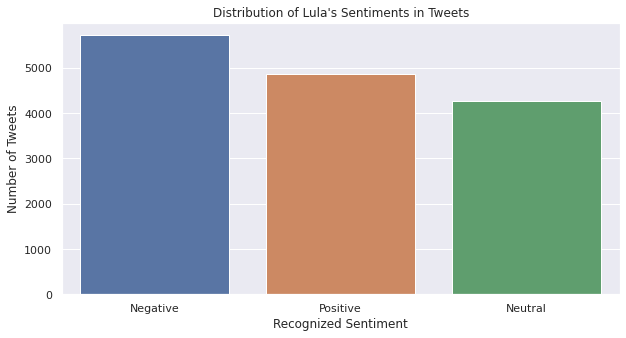

In [ ]:
import seaborn as sns
sns.set(rc={"figure.figsize":(10, 5)})
sns.countplot(x = "LeIA_label_cat", data = lula_df,
              order = lula_df['LeIA_label_cat'].value_counts().index)
plt.xlabel('Recognized Sentiment')
plt.ylabel('Number of Tweets')
plt.title("Distribution of Lula's Sentiments in Tweets")
plt.show()

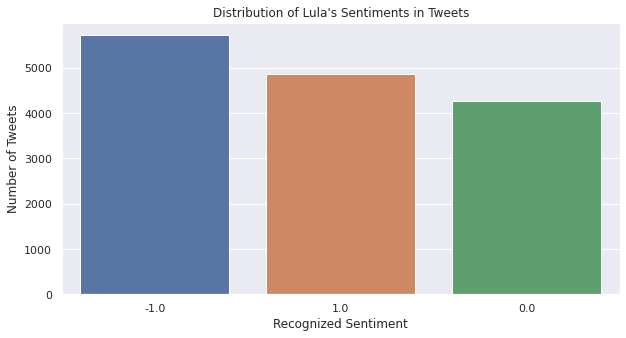

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.countplot(x = "LeIA_label_num", data = lula_df,
              order = lula_df['LeIA_label_num'].value_counts().index)
plt.xlabel('Recognized Sentiment')
plt.ylabel('Number of Tweets')
plt.title("Distribution of Lula's Sentiments in Tweets")
plt.show()

######Bolsonaro

In [ ]:
for index, row in bolsonaro_df['LeIA_label'].iteritems():
  print(index, row)
  if row['compound'] <= -0.05:
      bolsonaro_df.loc[index, "LeIA_label_cat"] = "Negative"
      bolsonaro_df.loc[index, "LeIA_label_num"] = -1
  elif row['compound'] >= 0.05:
      bolsonaro_df.loc[index, "LeIA_label_cat"] = "Positive"
      bolsonaro_df.loc[index, "LeIA_label_num"] = 1
  elif row['compound'] > -0.05 and row['compound'] < 0.05:
      bolsonaro_df.loc[index, "LeIA_label_cat"] = "Neutral"
      bolsonaro_df.loc[index, "LeIA_label_num"] = 0


A saída de streaming foi truncada nas últimas 5000 linhas.
7453 {'neg': 0.167, 'neu': 0.745, 'pos': 0.089, 'compound': -0.296}
7454 {'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'compound': 0.3182}
7455 {'neg': 0.0, 'neu': 0.776, 'pos': 0.224, 'compound': 0.6705}
7456 {'neg': 0.307, 'neu': 0.439, 'pos': 0.254, 'compound': -0.1531}
7457 {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.4215}
7458 {'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.836}
7459 {'neg': 0.0, 'neu': 0.604, 'pos': 0.396, 'compound': 0.8591}
7460 {'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'compound': 0.4019}
7461 {'neg': 0.0, 'neu': 0.903, 'pos': 0.097, 'compound': 0.4215}
7463 {'neg': 0.226, 'neu': 0.774, 'pos': 0.0, 'compound': -0.6605}
7464 {'neg': 0.197, 'neu': 0.702, 'pos': 0.1, 'compound': -0.4404}
7465 {'neg': 0.268, 'neu': 0.507, 'pos': 0.225, 'compound': -0.0516}
7466 {'neg': 0.052, 'neu': 0.717, 'pos': 0.231, 'compound': 0.6705}
7467 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
7468 {'neg': 

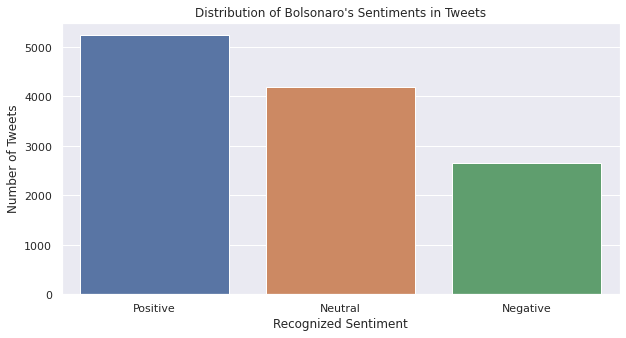

In [ ]:
import seaborn as sns
sns.set(rc={"figure.figsize":(10, 5)})
sns.countplot(x = "LeIA_label_cat", data = bolsonaro_df,
              order = bolsonaro_df['LeIA_label_cat'].value_counts().index)

plt.xlabel('Recognized Sentiment')
plt.ylabel('Number of Tweets')
plt.title("Distribution of Bolsonaro's Sentiments in Tweets")
plt.show()

In [ ]:
bolsonaro_df.head()

date      time               name  \
0  2022-08-08  20:26:17  Jair M. Bolsonaro   
1  2022-08-08  16:29:03  Jair M. Bolsonaro   
2  2022-08-08  16:29:03  Jair M. Bolsonaro   
3  2022-08-08  16:29:02  Jair M. Bolsonaro   
4  2022-08-08  09:35:36  Jair M. Bolsonaro   

                                               tweet  replies_count  \
0  Acompanhe, no horário, ao vivo, pelo Canal do ...            587   
1  - Entre os planos aplicados pela atual gestão ...            123   
2  - Recentemente priorizando o saneamento básico...            113   
3  - Longe do PT,  BNDES que patrocinava obras em...            937   
4  - Também, a ampliação do Teto do financiamento...            183   

   retweets_count  likes_count  \
0            2966        14734   
1            1523        10129   
2            1785        11423   
3            5075        23381   
4            2154        12326   

                                        tratamento_1  \
0               acompanhe horario canal flow podcast   
1  planos aplicados atual gestao carteira desesta...   
2  recentemente priorizando saneamento basico inf...   
3  longe pt bndes patrocinava obras ditaduras soc...   
4  ampliacao teto financiamento curso medicina au...   

                                        tratamento_2  \
0                 acompanh horari canal flow podcast   
1  plan aplic atual gesta cart desestatizaca clas...   
2  recent prioriz sane basic infraestrut bnd anun...   
3  long pt bnd patrocin obr ditad social deix inv...   
4  ampliaca tet financ curs medicin aument send n...   

                                        tratamento_3  \
0              acompanhar horario canal flow podcast   
1  plano aplicar atual gestao carteiro desestatiz...   
2  recentemente priorizar saneamento basico infra...   
3  longe pt bnde patrocinar obra ditaduro sociali...   
4  ampliacao teto financiamento curso medicina au...   

                                          LeIA_label LeIA_label_cat  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...        Neutral   
1  {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...       Positive   
2  {'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'comp...       Positive   
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...        Neutral   
4  {'neg': 0.0, 'neu': 0.642, 'pos': 0.358, 'comp...       Positive   

   LeIA_label_num  
0             0.0  
1             1.0  
2             1.0  
3             0.0  
4             1.0

In [ ]:
bolsonaro_df.loc[:, ['LeIA_label_cat', 'tweet', 'name']]

LeIA_label_cat                                              tweet  \
0            Neutral  Acompanhe, no horário, ao vivo, pelo Canal do ...   
1           Positive  - Entre os planos aplicados pela atual gestão ...   
2           Positive  - Recentemente priorizando o saneamento básico...   
3            Neutral  - Longe do PT,  BNDES que patrocinava obras em...   
4           Positive  - Também, a ampliação do Teto do financiamento...   
...              ...                                                ...   
12535       Negative  #debate64 O Governo se fez enérgico. Os q pega...   
12536       Negative  Em 64, o povo ñ suportava + greves, desordem s...   
12537       Positive  Os militares assumiram o governo em março de 6...   
12538       Positive  Me desculpem, boa noite @depchicoalencar @repo...   
12539       Positive  Boa noite a todos @depchicolanecar @reportercrime   

                    name  
0      Jair M. Bolsonaro  
1      Jair M. Bolsonaro  
2      Jair M. Bolsonaro  
3      Jair M. Bolsonaro  
4      Jair M. Bolsonaro  
...                  ...  
12535  Jair M. Bolsonaro  
12536  Jair M. Bolsonaro  
12537  Jair M. Bolsonaro  
12538  Jair M. Bolsonaro  
12539  Jair M. Bolsonaro  

[12068 rows x 3 columns]

In [ ]:
print('Neutro:', bolsonaro_df.loc[0, 'tweet'])

Neutro: Acompanhe, no horário, ao vivo, pelo Canal do Flow Podcast: https://t.co/eZTLTeqVEU https://t.co/mMHJnptC7M


In [ ]:
print('Positivo:', bolsonaro_df.loc[4, 'tweet'])

Positivo: - Também, a ampliação do Teto do financiamento para o curso de medicina foi aumentado em mais de 20%, em 2022, sendo mais uma novidade aos estudantes da área de saúde.
 
- Implemento de 22,8% passando do atual valor, R$ 42.983,70, para R$ 52.805,66.


In [ ]:
print('Negativo:', bolsonaro_df.loc[12535, 'tweet'])

Negativo: #debate64 O Governo se fez enérgico. Os q pegaram em armas, acusavam os militares de violentos, buscando votos e indenizações milionárias.


In [ ]:
lula_df['LeIA_label_cat'].value_counts()

Negative    5712
Positive    4861
Neutral     4270
Name: LeIA_label_cat, dtype: int64

In [ ]:
lula_df.loc[:, ['LeIA_label_cat', 'tweet', 'name']]

LeIA_label_cat                                              tweet  name
0           Negative  O Brasil piorou. A nova pesquisa do boletim De...  Lula
1           Positive  Nós estamos disputando com alguém que prometeu...  Lula
2           Positive  As mentiras contra Lula já aconteciam antes me...  Lula
3           Positive  Aprendi com minha mãe a não desistir. Quando v...  Lula
4           Positive  "Um dos meus sonhos é um dia estudar medicina....  Lula
...              ...                                                ...   ...
15135        Neutral  "Os trabalhadores estão com @dilmabr ",  diz o...  Lula
15136       Positive  @dilmabr e Lula saem agora pelas ruas de São B...  Lula
15137       Positive  Lula visita o @smabc e cumprimenta sindicalist...  Lula
15138        Neutral  Acompanhe notícias da caminhada também pelo @p...  Lula
15139        Neutral  Lula acaba de chegar ao @smabc de onde começar...  Lula

[14843 rows x 3 columns]

In [ ]:
print('Negativo:', lula_df.loc[0, 'tweet'])

Negativo: O Brasil piorou. A nova pesquisa do boletim Desigualdades nas Metrópoles mostra o que já vemos pelas ruas: aumento da miséria, fome e famílias sem um teto pra viver. Resultado de um governo que foi irresponsável por quatro anos e agora quer fingir trabalhar. #EquipeLula


In [ ]:
print('Positivo:', lula_df.loc[4, 'tweet'])

Positivo: "Um dos meus sonhos é um dia estudar medicina. Sei que tenho que estudar muito para ser aprovado no ENEM ou etc. Graças a você, filho de pobre tem chance de entrar em uma universidade. Lula você é esperança!" - Yuri, de Guaribas, Piauí, 13 anos ❤️#EquipeLula

🎥: @ricardostuckert https://t.co/SDDrXoO52w


In [ ]:
print('Neutro:', lula_df.loc[15135, 'tweet'])

Neutro: "Os trabalhadores estão com @dilmabr ",  diz o prefeito de São Bernardo do Campo, Luiz Marinho @marinhopt à população #LulaeDilmanoABC


#####LeIA

######Lula

In [ ]:

xtrain_lula, xtest_lula, ytrain_lula, ytest_lula = train_test_split(lula_df, lula_df['LeIA_label_num'], test_size=0.3, random_state=1)


train_lula, test_lula = train_test_split(lula_df, test_size=0.3, random_state=1)

t1_train_lula = train_lula[train_lula['LeIA_label_num']==1].sample(10000,replace=True)
t2_train_lula = train_lula[train_lula['LeIA_label_num']==-1].sample(10000,replace=True)
t3_train_lula = train_lula[train_lula['LeIA_label_num']==0].sample(10000,replace=True)
training_bs_lula = pd.concat([t1_train_lula, t2_train_lula, t3_train_lula])
"""
t1_test_lula = train_lula[train_lula['LeIA_label_num']==1].sample(10000,replace=True)
t2_test_lula = train_lula[train_lula['LeIA_label_num']==-1].sample(10000,replace=True)
t3_test_lula = train_lula[train_lula['LeIA_label_num']==0].sample(10000,replace=True)
testing_bs_lula = pd.concat([t1_test_lula, t2_test_lula, t3_test_lula])
"""
print("Candidato Luiz Inácio:")
print(f"Quantidade de amostras da base de treino originalmente: {train_lula.shape}")
print(f"Quantidade de amostras da base de treino após bootstrapping: {training_bs_lula.shape}")
print(f"Quantidade de amostras da base de teste: {test_lula.shape}\n")


lula_df.shape[0] == (train_lula.shape[0] + test_lula.shape[0])

Candidato Luiz Inácio:
Quantidade de amostras da base de treino originalmente: (10390, 13)
Quantidade de amostras da base de treino após bootstrapping: (30000, 13)
Quantidade de amostras da base de teste: (4453, 13)



True

In [ ]:
print(train_lula['LeIA_label_num'].value_counts(normalize=True))
baseline = 0.3

-1.0    0.382291
 1.0    0.329066
 0.0    0.288643
Name: LeIA_label_num, dtype: float64


In [ ]:
print(training_bs_lula['LeIA_label_num'].value_counts(normalize=True))
baseline = 0.3

 1.0    0.333333
-1.0    0.333333
 0.0    0.333333
Name: LeIA_label_num, dtype: float64


In [ ]:
training_bs_lula = training_bs_lula.reset_index(drop=True)
training_bs_lula.to_csv('/training_bs_lula.csv', header=True, index=False, encoding='UTF8')
test_lula = test_lula.reset_index(drop=True)
test_lula.to_csv('/testing_lula.csv', header=True, index=False, encoding='UTF8')

In [ ]:
training_lula = pd.read_csv('/training_bs_lula.csv', encoding='utf8')
X_train_lula = training_lula['tratamento_1']
y_train_lula = training_lula['LeIA_label_num']
#set up baseline
print(y_train_lula.value_counts(normalize=True))
baseline = 0.3

 1.0    0.333333
-1.0    0.333333
 0.0    0.333333
Name: LeIA_label_num, dtype: float64


In [ ]:
testing_lula = pd.read_csv('/testing_lula.csv', encoding='utf8')
X_test_lula = testing_lula['tratamento_1']
y_test_lula = testing_lula['LeIA_label_num']


In [ ]:
import statistics
lenn=[]
for tt in X_test_lula:
  lenn.append(len(tt))

print(statistics.mean(lenn))
print(max(lenn))



84.2481473164159
237


11.000666666666667


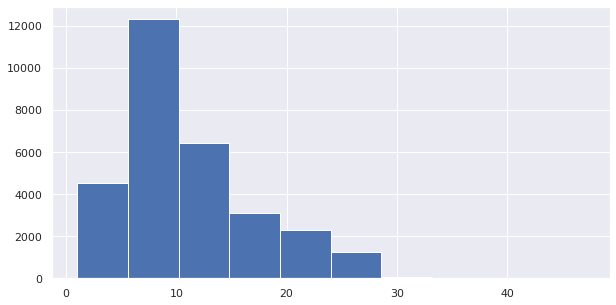

In [ ]:

train_lens = [len(i.split()) for i in X_train_lula]
plt.hist(train_lens)
print(statistics.mean(train_lens))


In [ ]:
#print(wordsPT, '\n', wordsPT_sentiments,'\n', train)


modelo = MultinomialNB(alpha=1)

classes_lula = training_lula["LeIA_label_num"].values
#classes = y_train
vectorizer = CountVectorizer()

freq_tweets_lula = vectorizer.fit_transform(X_train_lula)
freq_testes_lula = vectorizer.transform(X_test_lula)

modelo.fit(freq_tweets_lula, y_train_lula)

pred_lula = modelo.predict(freq_testes_lula)

print(pred_lula)
print(type(y_test_lula))

#y_test_lula_np = y_test_lula.to_numpy()

#acc_lula = modelo.score(y_test_lula_np, pred_lula)
#print(acc_lula)

acc1_lula = accuracy_score(y_test_lula, pred_lula)
print(acc1_lula)

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_lula.values.reshape(-1, 1), pred_lula))

#from sklearn.model_selection import cross_validate
#resultados_l = cross_validate(modelo, freq_tweets_lula, classes_lula)
#resultados_lula = cross_val_predict(modelo, freq_tweets_lula, classes_lula, cv = 3)
#print(resultados_lula)
#metrics.accuracy_score(classes_lula, resultados_lula)
#sentimentos = ["positivo", "negativo", "neutro"]
#print(metrics.classification_report(classes, resultados, sentimentos))

[ 1.  1.  1. ... -1. -1. -1.]
<class 'pandas.core.series.Series'>
0.6907702672355716
[[1363  151  226]
 [ 292  765  214]
 [ 293  201  948]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(pred_lula, y_test_lula.values.reshape(-1, 1)))

from sklearn.metrics import accuracy_score
print(accuracy_score(pred_lula, y_test_lula.values.reshape(-1, 1)))

from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(pred_lula, y_test_lula.values.reshape(-1, 1)))

              precision    recall  f1-score   support

        -1.0       0.78      0.70      0.74      1948
         0.0       0.60      0.68      0.64      1117
         1.0       0.66      0.68      0.67      1388

    accuracy                           0.69      4453
   macro avg       0.68      0.69      0.68      4453
weighted avg       0.70      0.69      0.69      4453

0.6907702672355716
[[[2128  377]
  [ 585 1363]]

 [[2830  506]
  [ 352  765]]

 [[2571  494]
  [ 440  948]]]


Text(66.5, 0.5, 'Predicted label')

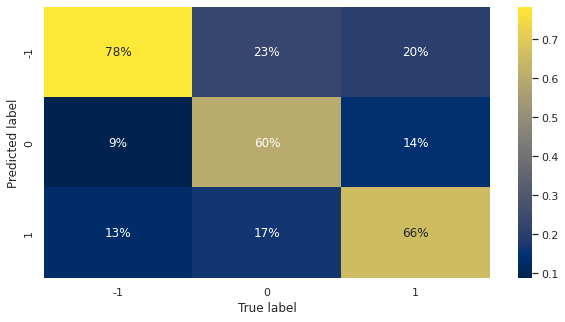

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Create the confusion matrix
conf_mat = confusion_matrix(y_test_lula, pred_lula, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel("True label")
plt.ylabel("Predicted label")

In [ ]:
print(len(pred_lula))

4453


http://computacaointeligente.com.br/outros/intro-sklearn-part-3/
https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html


######bolsonaro

In [ ]:
from sklearn.model_selection import train_test_split

xtrain_bolsonaro, xtest_bolsonaro, ytrain_bolsonaro, ytest_bolsonaro = train_test_split(bolsonaro_df, bolsonaro_df['LeIA_label_num'], test_size=0.3, random_state=1)


train_bolsonaro, test_bolsonaro = train_test_split(bolsonaro_df, test_size=0.3, random_state=1)

t_1_bolsonaro = train_bolsonaro[train_bolsonaro['LeIA_label_num']==1].sample(10000,replace=True)
t_2_bolsonaro = train_bolsonaro[train_bolsonaro['LeIA_label_num']==-1].sample(10000,replace=True)
t_3_bolsonaro = train_bolsonaro[train_bolsonaro['LeIA_label_num']==0].sample(10000,replace=True)
training_bs_bolsonaro = pd.concat([t_1_bolsonaro, t_2_bolsonaro, t_3_bolsonaro])

print("Candidato Jair Bolsonaro:")
print(f"Quantidade de amostras da base de treino originalmente: {train_bolsonaro.shape}")
print(f"Quantidade de amostras da base de treino após bootstrapping: {training_bs_bolsonaro.shape}")
print(f"Quantidade de amostras da base de teste: {test_bolsonaro.shape}\n")


bolsonaro_df.shape[0] == (train_bolsonaro.shape[0] + test_bolsonaro.shape[0])

Candidato Jair Bolsonaro:
Quantidade de amostras da base de treino originalmente: (8447, 13)
Quantidade de amostras da base de treino após bootstrapping: (30000, 13)
Quantidade de amostras da base de teste: (3621, 13)



True

In [ ]:
print(train_bolsonaro['LeIA_label_num'].value_counts(normalize=True))
baseline = 0.3

 1.0    0.433408
 0.0    0.349710
-1.0    0.216882
Name: LeIA_label_num, dtype: float64


In [ ]:
print(training_bs_bolsonaro['LeIA_label_num'].value_counts(normalize=True))
baseline = 0.3

 1.0    0.333333
-1.0    0.333333
 0.0    0.333333
Name: LeIA_label_num, dtype: float64


In [ ]:
training_bs_bolsonaro = training_bs_bolsonaro.reset_index(drop=True)
training_bs_bolsonaro.to_csv('/training_bs_bolsonaro.csv', header=True, index=False, encoding='UTF8')
test_bolsonaro = test_bolsonaro.reset_index(drop=True)
test_bolsonaro.to_csv('/testing_bolsonaro.csv', header=True, index=False, encoding='UTF8')

In [ ]:
training_bolsonaro = pd.read_csv('/training_bs_bolsonaro.csv', encoding='utf8')
X_train_bolsonaro = training_bolsonaro['tratamento_1']
y_train_bolsonaro = training_bolsonaro['LeIA_label_num']
#set up baseline
print(y_train_bolsonaro.value_counts(normalize=True))
baseline = 0.3

 1.0    0.333333
-1.0    0.333333
 0.0    0.333333
Name: LeIA_label_num, dtype: float64


In [ ]:
testing_bolsonaro = pd.read_csv('/testing_bolsonaro.csv', encoding='utf8')
X_test_bolsonaro = testing_bolsonaro['tratamento_1']
y_test_bolsonaro = testing_bolsonaro['LeIA_label_num']

In [ ]:
modelo = MultinomialNB(alpha=1)

classes_bolsonaro = training_bolsonaro["LeIA_label_num"].values
#classes = y_train
vectorizer = CountVectorizer()

freq_tweets_bolsonaro = vectorizer.fit_transform(X_train_bolsonaro)
freq_testes_bolsonaro = vectorizer.transform(X_test_bolsonaro)

modelo.fit(freq_tweets_bolsonaro, y_train_bolsonaro)

pred_bolsonaro = modelo.predict(freq_testes_bolsonaro)

print(len(pred_bolsonaro))
print(type(y_test_bolsonaro))

#y_test_lula_np = y_test_lula.to_numpy()

#acc_lula = modelo.score(y_test_lula_np, pred_lula)
#print(acc_lula)

acc1_bolsonaro = accuracy_score(y_test_bolsonaro, pred_bolsonaro)
print(acc1_bolsonaro)

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_bolsonaro.values.reshape(-1, 1), pred_bolsonaro))

#from sklearn.model_selection import cross_validate
#resultados_l = cross_validate(modelo, freq_tweets_lula, classes_lula)
#resultados_lula = cross_val_predict(modelo, freq_tweets_lula, classes_lula, cv = 3)
#print(resultados_lula)
#metrics.accuracy_score(classes_lula, resultados_lula)
#sentimentos = ["positivo", "negativo", "neutro"]
#print(metrics.classification_report(classes, resultados, sentimentos))

3621
<class 'pandas.core.series.Series'>
0.6650096658381662
[[ 554   73  186]
 [ 320  685  234]
 [ 258  142 1169]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(pred_bolsonaro, y_test_bolsonaro.values.reshape(-1, 1)))

from sklearn.metrics import accuracy_score
print(accuracy_score(pred_bolsonaro, y_test_bolsonaro.values.reshape(-1, 1)))

from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(pred_bolsonaro, y_test_bolsonaro.values.reshape(-1, 1)))

              precision    recall  f1-score   support

        -1.0       0.68      0.49      0.57      1132
         0.0       0.55      0.76      0.64       900
         1.0       0.75      0.74      0.74      1589

    accuracy                           0.67      3621
   macro avg       0.66      0.66      0.65      3621
weighted avg       0.68      0.67      0.66      3621

0.6650096658381662
[[[2230  259]
  [ 578  554]]

 [[2167  554]
  [ 215  685]]

 [[1632  400]
  [ 420 1169]]]


Text(66.5, 0.5, 'Predicted label')

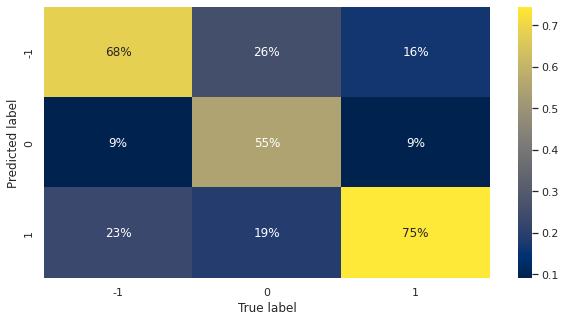

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Create the confusion matrix
conf_mat = confusion_matrix(y_test_bolsonaro, pred_bolsonaro, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel("True label")
plt.ylabel("Predicted label")

In [ ]:
"""
#print(wordsPT, '\n', wordsPT_sentiments,'\n', train)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

classes = training["LeIA_label_num"].values
#classes = y_train
vectorizer = CountVectorizer(analyzer = "word")
freq_tweets = vectorizer.fit_transform(X_train)

modelo = MultinomialNB()
modelo.fit(freq_tweets, y_train)
freq_testes = vectorizer.transform(X_test)
pred = modelo.predict(freq_testes)

resultados = cross_val_predict(modelo, freq_tweets, classes, cv = 3)
resultados
metrics.accuracy_score(classes, resultados)
#sentimentos = ["positivo", "negativo", "neutro"]
#print(metrics.classification_report(classes, resultados, sentimentos))
"""

'\n#print(wordsPT, \'\n\', wordsPT_sentiments,\'\n\', train)\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn import metrics\nfrom sklearn.model_selection import cross_val_predict\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.pipeline import make_pipeline\n\nclasses = training["LeIA_label_num"].values\n#classes = y_train\nvectorizer = CountVectorizer(analyzer = "word")\nfreq_tweets = vectorizer.fit_transform(X_train)\n\nmodelo = MultinomialNB()\nmodelo.fit(freq_tweets, y_train)\nfreq_testes = vectorizer.transform(X_test)\npred = modelo.predict(freq_testes)\n\nresultados = cross_val_predict(modelo, freq_tweets, classes, cv = 3)\nresultados\nmetrics.accuracy_score(classes, resultados)\n#sentimentos = ["positivo", "negativo", "neutro"]\n#print(metrics.classification_report(classes, resultados, sentimentos))\n'

#####textblob

######Lula

In [ ]:

tt_classificado = list()
#tt_analisado = list()

for tweet in lula_df['tratamento_1']:
  #analysis_polarity = TextBlob(tweet).polarity
  #print(analysis_polarity)
  #lula_df['SA TextBlob'] = sentiment(tweet) #Portuguese Dictionary
  blob_object_analyzer = TextBlob(tweet, analyzer=NaiveBayesAnalyzer())

  blob_object_classifier = cl.classify(tweet)
  prob_dist = cl.prob_classify(tweet)
  classification = prob_dist.max()
  tt_classificado.append(classification)
  #analysis = blob_object_analyzer.sentiment
  #tt_analisado.append(analysis)
  #print('analy:',analysis)

#lula_df["tratamento_0"] = tt_processado
#lula_df['SA TextBlob'] = np.array([sentiment(str(tweet)) for tweet in lula_df['tratamento_3']]) #Portuguese Dictionary

NameError: ignored

In [ ]:
lula_df['classe'] = tt_classificado

In [ ]:
for line in lula_df['classe']:
  if line == '':
    print('true')

In [ ]:
pos_tt = list()
neg_tt = list()

for index, row in lula_df.iterrows():
  if lula_df['classe'][index] > 0:
    pos = row['tratamento_1']
    pos_tt.append(pos)
  if lula_df['classe'][index] < 0:
    neg = row['tratamento_1']
    neg_tt.append(neg)
print(len(pos_tt), len(neg_tt))

In [ ]:
print(neg_tt[10])

In [ ]:
por_total_pos=len(pos_tt)*100/len(lula_df['tratamento_1'])
por_total_neg=len(neg_tt)*100/len(lula_df['tratamento_1'])
print(por_total_pos)

In [ ]:
todas_palavras_lula = ' '.join([tweet for tweet in lula_df.tratamento_1])

word_cloud_lula = WordCloud(width = 800, height = 500,
                                 max_font_size = 110,
                                 collocations = False).generate(todas_palavras_lula)
plt.figure(figsize = (10,7))
plt.imshow(word_cloud_lula, interpolation = 'bilinear')
plt.axis("off")
plt.show()
graf_pareto(lula_df, 'tratamento_1', 10)

In [ ]:
sentiments = ['Positivos', 'Negativos']
percents = [por_total_pos, por_total_neg]
pie_chart = pd.Series(percents, index=sentiments, name='Sentimentos')
colors = ['#ff9999','#66b3ff']
textprops = {"fontsize":10}
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(8, 8), colors=colors, textprops = textprops,labeldistance=1.2)
plt.title('Análise de sentimento dos tuítes de Lula por porcentagem', loc='center',fontsize=20)
plt.legend(labels=sentiments, loc='upper center',
           bbox_to_anchor=(0.5, -0.04), ncol=2)

plt.show()

######bolsonaro

In [ ]:
tt_classificadob = list()
#tt_analisado = list()

for tweet in bolsonaro_df['tratamento_1']:
  #analysis_polarity = TextBlob(tweet).polarity
  #print(analysis_polarity)
  #bolsonaro_df['SA TextBlob'] = sentiment(tweet) #Portuguese Dictionary
  blob_object_analyzer = TextBlob(tweet, analyzer=NaiveBayesAnalyzer())

  blob_object_classifier = cl.classify(tweet)
  prob_dist = cl.prob_classify(tweet)
  classification = prob_dist.max()
  tt_classificadob.append(classification)
  #analysis = blob_object_analyzer.sentiment
  #tt_analisado.append(analysis)
  #print('analy:',analysis)

#bolsonaro_df["tratamento_0"] = tt_processado
#bolsonaro_df['SA TextBlob'] = np.array([sentiment(str(tweet)) for tweet in bolsonaro_df['tratamento_3']]) #Portuguese Dictionary

In [ ]:
bolsonaro_df['classe'] = tt_classificadob

In [ ]:
for line in bolsonaro_df['classe']:
  if line == '':
    print('true')

In [ ]:
pos_ttb = list()
neg_ttb = list()

for index, row in bolsonaro_df.iterrows():
  if bolsonaro_df['classe'][index] > 0:
    pos = row['tratamento_1']
    pos_ttb.append(pos)
  if bolsonaro_df['classe'][index] < 0:
    neg = row['tratamento_1']
    neg_ttb.append(neg)
print(len(pos_ttb), len(neg_ttb))

In [ ]:
todas_palavras_b = ' '.join([tweet for tweet in bolsonaro_df.tratamento_1])

word_cloud_b = WordCloud(width = 800, height = 500,
                                 max_font_size = 110,
                                 collocations = False).generate(todas_palavras_b)
plt.figure(figsize = (10,7))
plt.imshow(word_cloud_b, interpolation = 'bilinear')
plt.axis("off")
plt.show()
graf_pareto(bolsonaro_df, 'tratamento_1', 10)

In [ ]:
por_total_posb=len(pos_ttb)*100/len(bolsonaro_df['tratamento_1'])
por_total_negb=len(neg_ttb)*100/len(bolsonaro_df['tratamento_1'])

In [ ]:
sentiments = ['Positivos', 'Negativos']
percents = [por_total_posb, por_total_negb]
pie_chart = pd.Series(percents, index=sentiments, name='Sentimentos')
colors = ['#ff9999','#66b3ff']
textprops = {"fontsize":10}
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(8, 8), colors=colors, textprops = textprops,labeldistance=1.2)
plt.title('Análise de sentimento dos tuítes de Bolsonaro por porcentagem', loc='center',fontsize=20)
plt.legend(labels=sentiments, loc='upper center',
           bbox_to_anchor=(0.5, -0.04), ncol=2)

plt.show()

######geral

In [ ]:
len_lula = len(lula_df)
len_bolsonaro = len(bolsonaro_df)

In [ ]:
perc_pos_lula = len(pos_tt)/len_lula
perc_pos_bolsonaro = len(pos_ttb)/len_bolsonaro

In [ ]:
print(ac_lula, ac_bolsonaro)

In [ ]:
print(neg_ttb)

In [ ]:
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(wordsPT)
modelo = MultinomialNB()
modelo.fit(freq_tweets,wordsPT_sentiments);


#####Carregando com SentiLex

In [ ]:
#Importando o Léxico de Palavras com polaridades
sentilexpt = open('/content/drive/MyDrive/UFRN/Mestrado/AM/SentiLex/SentiLex-lem-PT02.txt')

#Criando um dicionário de palavras com a respectiva polaridade.
dic_palavra_polaridade = {}
for i in sentilexpt.readlines():
  pos_ponto = i.find('.')
  palavra = (i[:pos_ponto])
  pol_pos = i.find('POL')
  polaridade = (i[pol_pos+7:pol_pos+9]).replace(';', '')
  dic_palavra_polaridade[palavra] = polaridade
#Verificando o dicionário

#dic_palavra_polaridade


In [ ]:
https://github.com/rdenadai/sentiment-analysis-2018-president-election/tree/master/dataset/emocoes


######score de sentimento

In [ ]:
#Criando uma função chamada "Score de Sentimento" para determinar os #sentimentos associados
def Score_sentimento(frase):
    l_sentimento = []
    for p in frase.split():
        l_sentimento.append(int(dic_palavra_polaridade.get(p, 0)))
    score = sum(l_sentimento)
    if score > 0:
        return 'Pos {} '.format(score)
    elif score == 0:
        return 'Neu {} '.format(score)
    else:
        return 'Neg {}'.format(score)


In [ ]:
#Criando uma função para aplicar um score de sentimento para cada um dos comentários, a partir das palavras positivas e negativas.
lula_df['sentimento'] = lula_df.apply(lambda row: Score_sentimento(row['tratamento_1']), axis=1)
#Reorganizando o resultado em colunas para posteriormente lançar no modelo
lula_df['Score_Sentimento'] = lula_df['sentimento'].str.slice(-2)
lula_df['Score_Sentimento'] = lula_df['Score_Sentimento'].astype(int)
lula_df['Sent'] = lula_df['sentimento'].str.slice(0,-3)
#Verificando como ficou a distribuição de comentários a partir do Score de Sentimento Criado.
lula_df.groupby('Score_Sentimento').count()


####lista exemplos extras

In [ ]:
lista = ('este trabalho e agradável',1),
('gosto de ficar no seu aconchego',1),
('fiz a adesão ao curso hoje porque eu gostei',1),
('eu sou admirada por muitos',1),
('adoro como você e',1),
('adoro seu cabelo macio',1),
('adoro a cor dos seus olhos',1),
('somos tão amáveis um com o outro',1),
('sinto uma grande afeição por ele',1),
('quero agradar meus filhos',1),
('me sinto completamente amado',1),
('eu amo você',1),
('que grande alivio',1),
('feliz ano novo', 1),
('a dor esta amenizando finalmente',1),
('acho que me apaixonei',1),
('amar e maravilhoso',1),
('estou me sentindo muito animada',1),
('me sinto muito bem hoje',1),
('como o luar e belo',1),
('o dia esta muito bonito',1),
('nossa como sou afortunado',1),
('as maravilhas do mundo',1),
('recebi muito carinho hoje do meus colegas',1),
('estou me sentindo reconfortada hoje',1),
('e muito bom estar com os amigos',1),
('estou muito contente com o resultado dos testes',1),
('essa pintura esta bem brilhante otimo trabalho',1),
('temos água em abundancia',1),
('que roupa delicada',1),
('você e um grande comediante',1),
('que bondade a sua em vir aqui',1),
('o amor e lindo',1),
('nossa amizade vai durar para sempre',1),
('estou eufórica com a noticia',1),
('ele e realmente fiel a mim',1),
('vou dar uma grande festa para comemorar meu aniversário',1),
('graças a deus que eu enxerguei o certo',1),
('essa e a melhor escolhas de todas',1),
('o mais incrível e você minha bela',1),
('e tão engraçado tentar explicar',1),
('e emocionante estar neste lugar',1),
('estou cativada pelo seu olhar',1),
('estou loucamente apaixonada',1),
('eu nunca tive duvidas',1),
('estou rodeada pelo seu abraço',1),
('eu vejo estrelas pelo caminho',1),
('eu sinto o sol sempre que você esta por perto',1),
('eu estou sorrindo de orelha a orelha',1),
('isso vale a pena',1),
('finalmente você colocou meu amor em primeiro lugar',1),
('nós dançamos noite adentro',1),
('seu amor e brilhante',1),
('toquei muitos corações durante o meu caminho',1),
('eu serei sua amiga e companheira',1),
('você me traz de volta a vida',1),
('você e como um sonho doce',1),
('adoro este doce de frutas',1),
('meu suco favorito',1),
('estou agradecida pela ajuda',1),
('e um enorme prazer ter você em nossa equipe',1),
('trabalhar em equipe e o melhor',1),
('me sinto flutuando no ar',1),
('a brisa esta agradável hoje',1),
('ótimo e compatível',1),
('somos compatíveis um com o outro',1),
('o órgão e compatível com o paciente',1),
('estou contente fui aceita na faculdade',1),
('fui aprovada no meu exame',1),
('fui beneficiada pela minha empresa',1),
('eu sou muito cativante',1),
('estou contente com o apoio',1),
('como este lugar e confortável',1),
('e bom estar quente neste frio',1),
('um elogio nunca e demais',1),
('vou te chamar para comemorar',1),
('e desejável a sua presença em nossa apresentação',1),
('sou muito grata a você',1),
('me dedico muito naquilo que faço',1),
('estou completamente apaixonada ',1),
('vamos agitar essa noite ',1),
('você significa muito para mim',1),
('vamos agir sem preconceitos e julgamentos',1),
('finalmente completei a minha coleção, maravilhoso',1),
('eu sou sua rainha ',1),
('satisfatoriamente eu anuncio o vencedor dos jogos',1),
('você me atrai facilmente ',1),
('aquele rapaz e extremamente atraente',1),
('sinto-me viva ',1),
('sinto-me em paz ',1),
('estamos tendo muito lucro',1),
('muito bem esta tudo em ordem agora ',1),
('podemos arrumar um emprego juntos ',1),
('a arrumação esta terminada, que alívio',1),
('o câncer e benigno ',1),
('o amor e abundante',1),
('vamos ser caridosos este natal',1),
('com todo esse charme você irá atrair a todos',1),
('nossa como você e charmoso querido ',1),
('sou querida pelos meu amigos',1),
('seja cuidadoso com os meus sentimentos',1),
('estou comovido com tamanha caridade',1),
('um chá quente e reconfortante',1),
('que 1 ter vocês aqui ',1),
('vamos aplaudir o vencedor ',1),
('palmas para a aniversariante',1),
('desejo a você tudo de bom',1),
('hora de apreciar um bom vinho',1),
('aprecio sua presença em minha escola',1),
('anseio por seus próximos trabalhos',1),
('maravilhoso jogo amistoso',1),
('e ótimo que os ânimos tenham se apaziguado',1),
('concretizei finalmente meu sonho',1),
('você e abominável',-1),
('nossa, que vontade de vomitar', -1),
('que banheiro porco', -1),
('eu caguei nas calcas', -1),
('bebi demais e preciso vomitar', -1),
('esta saindo pus do ferimento', -1),
('ele tem frieria e micose no pe', -1),
('o povo da praia ao lado joga tudo no chao, bando de porco', -1),
('abomino a maneira como você age',-1),
('estou adoentado',-1),
('meu pai esta adoentado',-1),
('estamos todos doentes',-1),
('essa situação e muito amarga',-1),
('disse adeus amargamente',-1),
('tenho antipatia por aquela pessoa',-1),
('como pode ser tão antipática!',-1),
('que horrível seu asqueroso',-1),
('tenho aversão agente como você',-1),
('isso tudo e só chateação',-1),
('estou muito chateada com suas mentiras',-1),
('tão desagradável',-1),
('isso me desagrada completamente',-1),
('te desagrada isso',-1),
('estou com enjôos terríveis',-1),
('todos estão enfermos',-1),
('foi uma enfermidade terrível',-1),
('isso e muito grave',-1),
('não seja tão grosseiro',-1),
('você fez uma manobra ilegal',-1),
('sua indecente, não tem vergonha?',-1),
('você e malvado com as crianças',-1),
('que comentário maldoso',-1),
('sem escrúpulos você manipula a tudo',-1),
('sinto repulsa por você',-1),
('e repulsivo a maneira como olha para as pessoas',-1),
('estou indisposta',-1),
('a indisposição me atacou hoje',-1),
('acho que vou vomitar',-1),
('tem muito vomito lá',-1),
('que incomodo essa dor',-1),
('não me incomode nunca mais',-1),
('suas bobagens estão nos incomodando',-1),
('que -1 olha toda essa sujeira',-1),
('como isso está sujo',-1),
('tenho náuseas só de lembrar',-1),
('me sinto nauseada com o cheiro desta comida',-1),
('você esta obstruindo a passagem de ar',-1),
('você esta terrivelmente doente',-1),
('olhe que feia esta roupa',-1),
('que atitude deplorável',-1),
('nossa como você e feio',-1),
('muito mau tudo isso',-1),
('estou -1so com você',-1),
('você cortou o meu assunto',-1),
('para que tanta chateação?',-1),
('esse perfume e enjoativo',-1),
('ser perigoso não nada bom',-1),
('você e perigoso demais para minha filhas',-1),
('que fetido este esgoto',-1),
('que fedido você esta',-1),
('que cachorro malcheiroso',-1),
('hora que ultraje',-1),
('e ultrajante da sua parte',-1),
('situação desagradável essa',-1),
('você só me da -1',-1),
('tenho aversão a pessoas assim',-1),
('antipatia e um mal da sociedade',-1),
('que criatura abominável',-1),
('e depressiva a maneira como você vê o mundo',-1),
('me desagrada sua presença na festa',-1),
('sinto asco dessa coisa',-1),
('que hediondo!',-1),
('vou golfar o cafe fora',-1),
('hora que garota detestável!',-1),
('estou nauseada',-1),
('isso que você disse foi muito grave',-1),
('não seja obsceno na frente das crianças',-1),
('não seja rude com as visitas',-1),
('esse assunto me da repulsa',-1),
('que criança terrivelmente travessa',-1),
('que criança mal educada',-1),
('estou indisposta te dar o divorcio',-1),
('tão patetico, não tem nada mais rude para dizer?',-1),
('por motivo torpe, com emprego de meio cruel e com impossibilidade de defesa para a vítima',-1),
('a inveja e tão vil e vergonhosa que ninguem se atreve a confessá-la',-1),
('o miserável receio de ser sentimental e o mais vil de todos os receios modernos',-1),
('travesso gato quando fica com saudades do dono mija no sapato',-1),
('isso e um ato detestável e covarde',-1),
('revelam apenas o que e destrutivo e detestável para o povo',-1),
('não sei como e a vida de um patife, mais a de um homem honesto e abominável',-1),
('há coisas que temos que suportar para não acharmos a vida insuportável',-1),
('as injurias do tempo e as injustiças do homem',-1),
('odioso e desumano',-1),
('você não publicará conteúdo odiento, pornográfico ou ameaçador',-1),
('rancoroso e reprimido',-1),
('não há animal mais degradante, estúpido, covarde, lamentável, egoísta, rancoroso e invejoso do que o homem',-1),
('o virulento debate ente políticos',-1),
('eu imploro, não me matem!',-1),
('tem certeza que não e perigoso?',-1),
('ele apontou uma arma para minha cabeca', -1),
('nao quero perder meu emprego, irei ficar pobre', -1),
('engordei dez quilos, nao quero ser gordo', -1),
('sera que aqui tem fantasma?', -1),
('eu nao entro no cemiterio nem morto', -1),
('encosto e esperito exitem', -1),
('fantasma e do mau', -1),
('o guima e cagao', -1),
('fantasma me da -1', -1),
('ferrou, o aviao esta caindo e vamos morrer', -1),
('eu me cago de -1 de entrar na favela sozinho', -1),
('tenho pavor de parque de diversoes, os brinquedos sao muito altos', -1),
('socorro, tem ladroes entrando em casa', -1),
('uma facada deve doer mais que um tiro', -1),
('tenho -1 de ficar pobre e nao ter seguranca para minha familia', -1),
('qual a necessidade dessa violencia, alguem pode se machucar fortemente', -1),
('estranho alguem ter -1 de chachorro, eles nao sao bravos', -1),
('eu nao pulo de para-quedas nem morto, morro de -1', -1),
('os presos la no pais Afeganistao sao torturados e sao quase mortos', -1),
('os bandidos estao morando aqui no bairro, proximo a favela', -1),
('eu nao posso perder ela, eu amo demais para ficar longe', -1),
('socorro, eu vi um fantasma', -1),
('eu tenho pavor de mar,morro de -1 de me afogar', -1),
('beira de abismo e loucura', -1),
('acabou a luz e fiquei com -1', -1),
('existe muitas pessoas ruins no mundo', -1),
('no mato ao lado de casa tem cobra e aranha, e perigoso', -1),
('eu nao saio sozinha de noite, so tem louco na rua', -1),
('arma de fogo e faca sao perigosos', -1),
('não tenho certeza se e seguro',-1),
('tenho que correr pra não me pegarem',-1),
('socorro! ele queria roubar os meus doces!',-1),
('esse cara está me perseguindo',-1),
('não entro lá, e um lugar muito perigoso',-1),
('este lugar continua assustador',-1),
('na selva tem muitos animais perigosos',-1),
('avancem com cautela',-1),
('este lugar está silencioso de mais, cuidado!',-1),
('por favor, deixe-me viver!',-1),
('vou ficar sem mesada se tirar nota baixa',-1),
('parece que tem olhos nos vigiando',-1),
('eu temo que a sentença do juiz possa ser negativa',-1),
('mas essa missão e arriscada',-1),
('salvem-se quem puder!',-1),
('meu plano pode ser descoberto',-1),
('não tive culpa, juro não fui eu',-1),
('tenho que tomar cuidado com o lobisomem',-1),
('se eu não achar, ele vai descobrir a verdade',-1),
('meu deus, ele desapareceu!',-1),
('tomara que eles não me vejam daqui!',-1),
('mantenha isso em segredo, se descobrirem estaremos ferrados',-1),
('por favor, me soltem, eu sou inocente',-1),
('estou ouvindo passos atrás de mim',-1),
('eu vou pedir socorro!',-1),
('cuidado com as curvas na estrada',-1),
('não sei não, parece perigoso',-1),
('estou tremendo de -1!',-1),
('socorro, eu vou cair!',-1),
('eu não vou ate a floresta negra, e muito perigoso',-1),
('ouço passos na minha direção',-1),
('acho que está arriscado de mais',-1),
('vamos voltar, e muito perigoso',-1),
('fuja, se não acabaremos mortos',-1),
('receio por não me livrar desta situação',-1),
('socorro! ele está armado!',-1),
('ei cuidado, você vai bater no poste!',-1),
('socorro, nós estamos afundando',-1),
('e serio, cuidado com essa arma!',-1),
('os tubarões estão atacando!',-1),
('sinto arrepios quando fico sozinho no escuro',-1),
('calma, eu não estou com o dinheiro',-1),
('eu acho que estou sendo enganado',-1),
('ligeiro, temos que fugir depressa',-1),
('tem um crocodilo selvagem vindo para cá',-1),
('se ficarmos quietos eles não vão nos achar',-1),
('fuja! o tigre parece faminto',-1),
('estou sem saída, preciso de um milagre',-1),
('tire isso de mim! socorro!',-1),
('não sei nadar, vou me afogar!',-1),
('não tenho certeza se e seguro',-1),
('vou apanhar se meus pais verem meu boletim',-1),
('não consigo sair daqui!',-1),
('se sair tão tarde, poderei ser assaltada',-1),
('não me deixe por favor!',-1),
('espere, não pode me largar aqui sozinho',-1),
('temo pela sua segurança',-1),
('eu te entrego o dinheiro, por favor não me mate!',-1),
('ele vai levar todo o meu dinheiro',-1),
('não dirija tão rápido assim',-1),
('me descobriram, irão me prender!',-1),
('só espero que não me façam nenhum mal',-1),
('vou me afogar, me ajudem a sair da água',-1),
('não estaremos a salvo aqui',-1),
('não quero nem pensar no que pode acontecer',-1),
('nessa cidade e uma desgraça atrás da outra',-1),
('alguem esta me ligando, estou assustado',-1),
('isso não e remedio, não me matem',-1),
('eu não confio nele, tenho que ter cautela',-1),
('muita cautela',-1),
('vou ser descoberto, meu deus',-1),
('receio que terei de ir',-1),
('a noite e muito perigosa',-1),
('estou estremecendo com essa casa',-1),
('olha aquela criatura se movendo monstruosamente',-1),
('não agüento este suspense',-1),
('afugente os cães',-1),
('estou chocado e amedrontado com este assassinato brutal',-1),
('e preciso afugenta com ímpeto este -1 do inferno',-1),
('seu políticos usam suas forças para afugentar e amedrontar o povo',-1),
('o objetivo disso e apenas me amedrontar mais',-1),
('isso me apavora',-1),
('ele a feriu profundamente',-1),
('eu vou matar ele', -1),
('que droga, eu nao passei de ano na escola, pqp', -1),
('pqp, tomei dez multas de transito', -1),
('que droga, perdi tudo no cassino', -1),
('me roubaram na rua', -1),
('esse trouxa me deixou esperando', -1),
('vou despejar minha cólera em você',-1),
('me sinto atormentado',-1),
('não me contrarie',-1),
('meu time perdeu ontem', -1),
('so chove nesse lugar, que merda', -1),
('tirei ferias e fui despedido', -1),
('fui despedido por justa causa', -1),
('vou despedir aquele imcompetente', -1),
('bando de filho da puta, que -1 disso tudo', -1),
('nada mais faz sentido, que droga', -1),
('que lerdeza isso', -1),
('demora demais a fila', -1),
('nunca vai rapido a fila, sempre demora', -1),
('perdi todo meu dinheiro', -1),
('so tem gente feia nessa festa, vamos embora', -1),
('vou destruir tudo  que foi construído',-1),
('não consigo terminar este trabalho, e muito frustrante',-1),
('me frustra a sua presença aqui',-1),
('esta comida me parece muito ruim',-1),
('você me destrói',-1),
('estamos separados',-1),
('estou odiando este vestido',-1),
('não pude comprar meu celular hoje',-1),
('ela e uma garota ruim',-1),
('estivemos em um show horroroso',-1),
('o ingresso estava muito caro',-1),
('se eu estragar tudo vai por água a baixo',-1),
('não possuo dinheiro algum',-1),
('sou muito pobre',-1),
('vai prejudicar a todos esta nova medida',-1),
('ficou ridículo',-1),
('este sapato esta muito apertado',-1),
('a musica e uma ofensa aos meus ouvidos',-1),
('não consigo terminar uma tarefa muito difícil',-1),
('reprovei em minha graduação',-1),
('estou muito chateado com tudo',-1),
('eu odeio em você',-1),
('e um desprazer conhecê-lo',-1),
('estou desperdiçando minhas ferias',-1),
('e muito ruim este jogo',-1),
('vamos ter muito rancor pela frente',-1),
('não achei que seria tão terrível',-1),
('vou vetar o orçamento ao cliente',-1),
('meus pais não consentiram nosso casamento',-1),
('eu odiei este perfume',-1),
('seu descaso e frustrante',-1),
('me sinto completamente amarga',-1),
('desprezo muito o seu trabalho',-1),
('estamos descontentes por nossa família',-1),
('vou infernizar a sua empresa',-1),
('estou furioso com estes valores',-1),
('obrigaram o rapaz a sair',-1),
('como ele pode deixar de lado?',-1),
('são apenas injurias sobre mim',-1),
('estou enfurecido com a situação dessa empresa',-1),
('estou com o diabo no corpo',-1),
('isso foi diabólico',-1),
('tenho aversão à gente chata',-1),
('não vou perdoar sua traição',-1),
('esse dinheiro sujo e corrupto',-1),
('eles me crucificam o tempo todo',-1),
('eu vou enlouquecer com todo este barulho',-1),
('não agüento todo esse assedio',-1),
('cólera do dragão',-1),
('isso e ridículo!',-1),
('da próxima vez, vou inventar tudo sozinho',-1),
('seus tolos! deixaram ele escapar!',-1),
('jamais te perdoarei',-1),
('o que e isso? outra multa',-1),
('você passou dos limites!',-1),
('sente-se e cale a boca',-1),
('ingratosvermesvocês me pagam!',-1),
('saiam da dai, se não arranco vocês dai!',-1),
('você já me causou problemas suficientes',-1),
('que transito maldito, perdi muito tempo parado aqui nessa porra', -1),
('porra, eu nao quero esperar nada, sai da minha frente', -1),
('a bebida esquentou demais, estou muito puto com essa porra', -1),
('ele me traiu com aquela vadia, filho da puta', -1),
('uma palavra a mais e eu ja mandaria calar a boca', -1),
('eu nao tenho paciencia com gente lerda e burra', -1),
('preconceito me da muita -1, que povo mais escroto', -1),
('estou nervoso com esta situacao, eu nao mereco passar esta barra sozinho, estou para matar alguem', -1),
('eu estou bastante  e mesma assim nao passei no teste, que merda', -1),
('eu faco dieta e constinuo engordando', -1),
('isso foi a gota d’agua',-1),
('o que você tem com isso?',-1),
('não vejo a hora de me livrar de você',-1),
('já entendi a jogada seus safados!',-1),
('você não merece piedade',-1),
('saia de perto de mim',-1),
('suma daqui, ou arranco seu couro!',-1),
('estou revoltado com essa situação',-1),
('seu idiota!',-1),
('não, eu não vou te emprestar dinheiro!',-1),
('você não passa de um cafajeste! vai embora',-1),
('pare de frescura e vá trabalhar',-1),
('eles merecem uma lição',-1),
('ainda estou muito bravo com você',-1),
('eu preciso surrar aquela chantagista',-1),
('olha o que você fez! derramou!',-1),
('você está pedindo pra apanhar!',-1),
('me deixa em paz!',-1),
('morra maldito, morra!',-1),
('você e mais irritante de perto',-1),
('e bom fechar o bico',-1),
('magicamente você me surpreendeu',0),
('e imenso esse globo',0),
('uau que noticia bacana', 0),
('uau, eu tambem quero um carro desse para mim', 0),
('eu nao esperava ele me pedir em casamento, que noticia surpreendente', 0),
('sera que iremos conseguir fugir?', 0),
('descobri que estou gravida', 0),
('qual o resultado do teste?', 0),
('fascinante esse filme, eu adorei', 0),
('que susto, eu nao esperava', 0),
('ue, eu achei que iria chover hoje', 0),
('nunca se sabe', 0),
('quem sera o assassino', 0),
('voce nunca sabera se e homem ou mulher', 0),
('isso e tremendamente interessante',0),
('meu bilhete for sorteado, inacreditável!',0),
('um assalto a mão armada!',0),
('incrível, cabe em qualquer lugar!',0),
('você por aqui?',0),
('não dá pra acreditar no que ela me contou',0),
('os convidados já estão chegando!',0),
('puxa vida! nunca nos livramos de alguem tão depressa',0),
('micha carteira sumiu, eu estava com ela na mão',0),
('oh! um disco voador',0),
('amigos, que bela 0!',0),
('nunca pensei que veria isso e perto',0),
('nem acredito que comi tanto',0),
('não acredito que veio me ver',0),
('não acredito que e  tão descarado',0),
('me surpreende sua falta de tato',0),
('o predio onde eles moravam desabou!',0),
('inacreditável um bolo tão grande',0),
('e serio mesmo? não dá pra acreditar',0),
('como assim não vai ao nosso encontro?',0),
('como assim não tem ninguem em casa?',0),
('ue, mas para onde ele foi?!',0),
('por essa eu não esperava',0),
('nossa, olha só que mergulho',0),
('minha esposa está grávida!',0),
('meu dinheiro sumiu!',0),
('e verdade que os dois terminaram?!?',0),
('caramba, nem vi você chegar',0),
('nossa, como pode alguem cozinhar tão mal?',0),
('nossa que incrível',0),
('a fórmula sumiu!',0),
('eu nem acredito que já estou terminando o curso',0),
('não acredito que esta aqui comigo novamente',0),
('está escondendo algo de nós!',0),
('como assim, ainda não terminou a tarefa',0),
('pensei que já estivesse pronta!',0),
('opa! quem apagou a luz?',0),
('caramba! aonde vai tão rápido?',0),
('estamos seguindo o caminho errado!',0),
('quatro reais o litro da gasolina!',0),
('me assustei ao vê-lo desse jeito!',0),
('minha mãe está grávida, acredita nisso?',0),
('parece mentira você ter crescido tanto',0),
('me surpreende sua imaginação',0),
('suas roupas são realmente lindas',0),
('com consegue ser tão bela?',0),
('essa e realmente uma casa deslumbrante',0),
('superou minhas expectativas',0),
('e admirável a maneira como se comporta',0),
('isso e realmente chocante',0),
('algumas noticias me surpreenderam no noticiário',0),
('surpreendente sua festa',0),
('nossa, que top esse filme!, eu nao esperava', 0),
('cheguei atrasado e me assim consegui entregar o resultado, ufa!', 0),
('ufa, essa foi por pouco, quase caimos fora', 0),
('quem sabe na proxima vida', 0),
('estou tremendo de 1',0),
('chocou grande parte do mundo',0),
('eu ficaria muito espantado com a sua vinda',0),
('ele e admirável',0),
('sua beleza me surpreendeu',0),
('seus olhos são surpreendentemente verdes',0),
('os políticos se surpreendem quando alguem acredita neles',0),
('estou perplexa com essas denuncias',0),
('fiquei perplexo com suas palavras',0),
('estou abismado com sua prosa',0),
('eu ficaria realmente abismado se me dissessem isso',0),
('o grupo foi surpreendido enquanto lavava o carro',0),
('estou boquiaberto com as imagens',0),
('estou boquiaberto com essas suas palavras',0),
('esse quadro e maravilhoso',0),
('este carro me deixou maravilhado',0),
('estou maravilhada',0),
('pqp, voce e gay?', 0),
('qual sera o meu salario ano que vem?', 0),
('essa expectativa esta me matando',0),
('vou caminhar sempre na expectativa de encontrá-lo',0),
('você emudece minhas palavras',0),
('minhas palavras vão emudecer se não parar de me surpreender',0),
('a mulher e um efeito deslumbrante da natureza',0),
('estou deslumbrada com essas jóias',0),
('isso e romântico e deslumbrante',0),
('isso pode ser surpreendentemente deslumbrante',0),
('trabalho deslumbrante',0),
('essas pessoas são esplêndida',0),
('e esplendido como o ceu se encontra no momento',0),
('e um carro fantástico',0),
('um edifício realmente fantástico',0),
('por favor não me abandone',-1),
('não quero ficar sozinha',-1),
('não me deixe sozinha',-1),
('estou abatida',-1),
('ele entrou em coma para sempre, que dó', -1),
('uma bacteria matou a populacao inteira', -1),
('a miseria tomou conta do pais todo', -1),
('pobreza e miseria matam todos de fome no mundo', -1),
('eu nao aguento mais viver sem ele', -1),
('eu trabalho muito e nao ganho nada, e triste', -1),
('cancer e triste demais', -1),
('qualquer doenca e terrivel', -1),
('sofrer acidente com trauma e muito dramatico', -1),
('saber que funkeiro ganha mais que professor e de doer o coracao', -1),
('bati o carro no poste, me ferrei', -1),
('acabaram minhas ferias', -1),
('ficar doente e muito ruim', -1),
('ele me traiu com um vadia', -1),
('meus pais estao doentes', -1),
('depressao e uma doenca silenciosa e mortal', -1),
('ela perdeu o emprego e entrou em depressao profunda', -1),
('amputar um membro devido a doenca e triste demais', -1),
('filhos pequenos foram separados dos pais na fronteira, que -1', -1),
('os animais sao cacados e mortos a toa, sem razao nenhuma, eu morro de dó', -1),
('sacrificar os animais devido a ganancia e muito triste', -1),
('e bizarro o quanto morre de fome na africa', -1),
('qualquer doenca que cause sequelas e terrivel', -1),
('a guerra so traz destruicao e pobreza', -1),
('saudade faz muito mal para o coracao', -1),
('ele esta todo abatido',-1),
('tão triste suas palavras',-1),
('seu amor não e mais meu',-1),
('estou aborrecida',-1),
('isso vai me aborrecer',-1),
('estou com muita aflição',-1),
('me aflige o modo como fala',-1),
('estou em agonia com meu intimo',-1),
('não quero fazer nada',-1),
('me sinto ansiosa e tensa',-1),
('não consigo parar de chorar',-1),
('não consigo segurar as lagrimas',-1),
('e muita dor perder um ente querido',-1),
('estou realmente arrependida',-1),
('acho que o carma volta, pois agora sou eu quem sofro',-1),
('você não cumpriu suas promessas',-1),
('me sinto amargurada',-1),
('coitado esta tão triste',-1),
('já e tarde de mais',-1),
('nosso amor acabou',-1),
('essa noite machuca só para mim',-1),
('eu não estou mais no seu coração',-1),
('você mudou comigo',-1),
('quando eu penso em você realmente dói',-1),
('como se fosse nada você vê minhas lagrimas',-1),
('você disse cruelmente que não se arrependeu',-1),
('eu nunca mais vou te ver',-1),
('ela esta com depressão',-1),
('a depressão aflige as pessoas',-1),
('estar depressivo e muito ruim',-1),
('estou derrotada e deprimida depois deste dia',-1),
('e comovente te ver dessa maneira',-1),
('e comovente ver o que os filhos do brasil passam',-1),
('como me sinto culpada',-1),
('estou abatida',-1),
('a ansiedade tomou conta de mim',-1),
('as pessoas não gostam do meu jeito',-1),
('adeus passamos bons momentos juntos',-1),
('sinto sua falta',-1),
('ele não gostou da minha comida',-1),
('estou sem dinheiro para a comida',-1),
('queria que fosse o ultimo dia da minha vida',-1),
('você está com vergonha de mim',-1),
('ela não aceitou a minha proposta',-1),
('era o meu ultimo centavo',-1),
('reprovei de ano na faculdade',-1),
('afinal você só sabe me desfazer',-1),
('eu falhei em tudo nessa vida',-1),
('eu fui muito humilhado',-1),
('e uma história muito triste',-1),
('ninguem acredita em mim',-1),
('eu não sirvo para nada mesmo',-1),
('droga, não faço nada direito',-1),
('sofrimento em dobro na minha vida',-1),
('fui demitida essa semana',-1),
('as crianças sofrem ainda mais que os adultos',-1),
('pra mim um dia e ruim, o outro e pior',-1),
('de repente perdi o apetite',-1),
('oh que dia infeliz',-1),
('estamos afundados em contas',-1),
('nem um milagre pode nos salvar',-1),
('só me resta a esperança',-1),
('pior que isso não pode ficar',-1),
('meu salário e baixo',-1),
('não passei no vestibular',-1),
('ninguem se importa comigo',-1),
('ninguem lembrou do meu aniversário',-1),
('tenho tanto azar',-1),
('o gosto da vingança e amargo',-1),
('sou uma mulher amargurada depois de que você me deixou',-1),
('estou desanimada com a vida',-1),
('e um desanimo só coitadinha',-1),
('a derrota e depressiva',-1),
('discriminar e desumano',-1),
('que desanimo',-1),
('e uma desonra para o pais',-1),
('a preocupação deveria nos levar a ação não a depressão',-1),
('passamos ao desalento e a loucura',-1),
('aquele que nunca viu a -1 nunca reconhecerá a 1',-1),
('cuidado com a -1 ela e um vicio',-1),
('não precisei pagar o ingresso',1),
('se eu ajeitar tudo fica bem',1),
('minha fortuna ultrapassa a sua',1),
('sou muito afortunado',1),
('e benefico para todos esta nova medida',1),
('ficou lindo',1),
('achei esse sapato muito simpático',1),
('estou ansiosa pela sua chegada',1),
('congratulações pelo seu aniversário',1),
('delicadamente ele a colocou para dormir',1),
('a musica e linda',1),
('sem musica eu não vivo',1),
('conclui uma tarefa muito difícil',1),
('conclui minha graduação',1),
('estou muito contente com tudo',1),
('eu confio em você',1),
('e um prazer conhecê-lo',1),
('o coleguismo de vocês e animador',1),
('estou aproveitando as ferias',1),
('vamos aproveitar as ferias',1),
('e muito divertido este jogo',1),
('vamos ter muita diversão',1),
('não achei que me divertiria tanto assim',1),
('vou consentir o orçamento ao cliente',1),
('com o consentimento dos meus pais podemos nos casar',1),
('eu adorei este perfume',1),
('sua bondade e cativante',1),
('estou despreocupada',1),
('não me preocupo com o que aconteceu',1),
('me sinto completamente segura',1),
('estimo muito o seu trabalho',1),
('somos estimados por nossa família',1),
('concretizamos nossa ideia',1),
('nosso ideal foi alcançado',1),
('estamos muito felizes juntos',1),
('estou tão animada com os preparativos para o casamento',1),
('você será muito amado meu filho',1),
('os apaixonados são maravilhosos',1),
('agradeço imensamente o seu apoio nestes dias',1),
('esta comida me parece muito atraente',1),
('você me completa',1),
('poderemos completar o projeto hoje!',1),
('estamos namorando',1),
('estou namorando este vestido a um tempo',1),
('pude comprar meu celular hoje',1),
('e um deleite poder compartilhar minhas vitórias',1),
('ela e um boa garota',1),
('estivemos em um ótimo show',1),
('o mundo e feio como o pecado',-1),
('a coisa mais difícil de esconder e aquilo que não existe',-1),
('você errou feio aquele gol',-1),
('nunca vou me casar sou muito feia',-1),
('os golpes da adversidade são terrivelmente amargos',-1),
('os homem ficam terrivelmente chatos',-1),
('abominavelmente convencido',-1),
('terrivelmente irritado',-1),
('eu bebi demais e vomitei', -1),
('eu nao limpo banheiro nem morto', -1),
('nossa, que cheiro de bosta! esta muito fedido', -1),
('esta fedido demais aqui', -1),
('esse peixe esta podre, nao coma', -1),
('ele foi jantar sem lavar as maos, que porco', -1),
('nao tem hijeine nenhuma aqui, lixo!', -1),
('as instituições publicas estão terrivelmente decadentes',-1),
('a população viveu em isolamento por muito tempo',-1),
('estou terrivelmente preocupada',-1),
('o nacionalismo e uma doença infantil',-1),
('se me es antipático a minha negação esta pronta',-1),
('muitos documentários sobre esse casal antipático',-1),
('sua beleza não desfaça sua antipatia',-1),
('esta e uma experiência desagradável',-1),
('o homem cuspiu na rua', -1),
('a comida estava estragada', -1),
('comer inseto e nojento', -1),
('desagradável estrago nos banheiros',-1),
('o mais irritante no amor e que se trata de um crime que precisa de um cúmplice',-1),
('a situação nos causa grande incomodo',-1),
('estou preocupado com o incomodo na garganta',-1),
('simplesmente não quero amolação da policia',-1),
('você e uma criaturinha muito impertinente',-1),
('o peso e a dor da vida',-1),
('me arrependo amargamente de minhas ações',-1),
('o destino e cruel e os homens não são dignos de compaixão',-1),
('o ódio conduz ao isolamento cruel e ao desespero',-1),
('encerrou com o massacre mais repudiável e asqueroso que se conhece',-1),
('de mal gosto e asqueroso',-1),
('tudo e inserto neste mundo hediondo',-1),
('o crime de corrupção e um crime hediondo',-1),
('o rio esta fetido e de cor escura',-1),
('muito lixo no rio o deixa malcheiroso',-1),
('existe uma laranja podre no grupo e já desconfiamos quem e',-1),
('foi de repente estou machucado e me sentindo enjoado',-1),
('eu fiquei enojado',-1),
('daqui alguns meses vou embora deste pais que já estou nauseado',-1),
('que abominável esse montro!',-1),
('vamos alarmar a todos sobre a situação',-1),
('estou amedrontada',-1),
('estou com muito -1 da noite',-1),
('ele esta me ameaçando a dias',-1),
('quanta angustia',-1),
('eu nao gosto de arma, e perigoso', -1),
('qualquer um tem -1 de alguem armado', -1),
('arrumar briga hoje em dia e muito perigoso', -1),
('eu nao reajo em nenhum assalto, to fora!', -1),
('esses bichos: cobra, aranha, escorpiao sao horriveis, eu tenho muito -1', -1),
('nossa que alto aqui, eu nao gosto de altura', -1),
('montanha-russa da muito -1, geralmente eu nao tenho coragem', -1),
('estou angustiada',-1),
('angustiadamente vou sair e casa',-1),
('isso me deixa apavorada',-1),
('você esta me apavorando',-1),
('estou desconfiada de você',-1),
('não confio em você',-1),
('ate o cachorro está apavorado',-1),
('estou assustado com as ações do meu colega',-1),
('agora se sente humilhado, apavorado',-1),
('assustou a população e provocou mortes',-1),
('estou com dificuldades para respirar e muito assustado',-1),
('os policiais se assustaram quando o carro capotou',-1),
('o trabalhador e assombrado pelo temor do desemprego',-1),
('este lugar e mal assombrado',-1),
('estou assombrado pela crise financeira',-1),
('mesmo aterrorizado lembro de você',-1),
('aterrorizado e suando frio',-1),
('um grupo de elefantes selvagens tem aterrorizado vilas',-1),
('me sinto intimidada pela sua presença',-1),
('tenho -1 de ser advertida novamente',-1),
('estou correndo o risco de ser advertido',-1),
('estou correndo riscos de saúde',-1),
('os riscos são reais',-1),
('podemos perder muito dinheiro com essa investida',-1),
('socorro, fui intimado a depor',-1),
('fui notificado e estou com -1 de perde a guarda da minha filha',-1),
('estou angustiada com meus filhos na rua',-1),
('e abominável o que fazem com os animais',-1),
('foi terrível o tigre quase o matou',-1),
('me advertiram sobre isso',-1),
('ate que enfim, não agüentava mais te esperar',-1),
('eu quero meu dinheiro de volta agora!',-1),
('eu odeio a escola!',-1),
('pqp, que merda de festa', -1),
('eu nunca tiro notas altas, que droga', -1),
('fiquei chapado e bati o carro, pqp que -1', -1),
('nao passei no vestibular por pouco, ridiculo esse teste!', -1),
('vou fazer picadinho de você',-1),
('detesto trabalhar no verão',-1),
('quero minha comida, e quero agora!',-1),
('melhor você recolher minhas compras agora!',-1),
('quero descer agora sua maluca',-1),
('vou reclamar com o gerente!',-1),
('vai engolir o que disse!',-1),
('ele me ridiculariza diante de todos',-1),
('não quero mais saber de você',-1),
('vejo você na cadeia safado!',-1),
('agora vou ter que pagar mais isso ainda!',-1),
('saia logo do banheiro!',-1),
('suba já para o seu quarto!',-1),
('eu falei para calar a boca seu idiota!',-1),
('eu disse para você cair fora!',-1),
('não agüento mais que fiquem me culpando sem motivo!',-1),
('não suporto olhar na sua cara!',-1),
('eu não sou um elefante',-1),
('juro que se olhar pra mim eu o mato!',-1),
('chega, não quero saber mais deste assunto',-1),
('como pode ser tão burro?',-1),
('não me aborreça seu moleque',-1),
('não quero me aborrecer com estas bobagens',-1),
('ele me agrediu!',-1),
('eu amaldiçôo você e a sua família',-1),
('não me amole',-1),
('não venha me amolar',-1),
('isso tudo e uma tormenta',-1),
('eu vou matar você',-1),
('para que simplificar se você pode sempre complicar',-1),
('isso esta me enlouquecendo',-1),
('estou furiosa com você',-1),
('isso mesmo fique furioso',-1),
('esses livros são magníficos',0),
('esse vinho e magnífico',0),
('seria magnífico ver o esperaculo',0),
('o casamento foi estupendo',0),
('e um jogador bárbaro estupendo',0),
('esse dia esta excelente',0),
('o cantor estava excelente',0),
('o universo e assombroso',0),
('o amor e sublime',0),
('sua sublime atuação',0),
('e formidável meu caro walter',0),
('eu nao acredito! voce e gay?', 0),
('nossa, que noticia explendida!', 0),
('eu nao imaginava isso, que noticia boa', 0),
('como e formidável a presença de todos',0),
('e formidável ter a quem dizer adeus',0),
('e um conselheiro formidável o seu',0),
('o artigo foi formidável',0),
('pica pau e um destaque no imaginário brasileiro',0),
('ah! o absoluto do imaginário',0),
('isso foi surreal',0),
('uma historia completamente surreal',0),
('essas pinturas beiram o surreal',0),
('você nem acreditam de tão surreal',0),
('incrível!',0),
('fiquei pasma com tudo isso',0),
('você me deixa pasmo',0),
('estou admirado com a sua astucia',0),
('que bela 0 você me fez',0),
('não acredito que fez isso!',0),
('isso foi apavorante',0),
('isso tão de repente',0),
('estou chocada com isso',0),
('estou 0 e desconsertada',0),
('esta realmente deslumbrante querida',0),
('fiquei completamente sem plavras',0),
('e espantoso o modo como ele nos olha',0),
('incrivel você estar aqui',0),
('que fantástica festa minha querida',0),
('isso tudo e um erro',-1),
('eu sou errada eu sou errante',-1),
('tenho muito dó do cachorro',-1),
('e dolorida a perda de um filho',-1),
('essa tragedia vai nos abalar para sempre',-1),
('perdi meus filhos',-1),
('ela nao para de chorar a morte do marido', -1),
('ela perdeu um filho no aborto', -1),
('os pais deles morreram em um acidente', -1),
('o aviao caiu no mar e nao tiveram mais noticias', -1),
('perdi meu curso',-1),
('sou só uma chorona',-1),
('você e um chorão',-1),
('se arrependimento matasse',-1),
('me sinto deslocado em sala de aula',-1),
('foi uma passagem fúnebre',-1),
('nossa condolências e -1 a sua perda',-1),
('desanimo, -1, solidão ou vazies, depressão',-1),
('vivo te desanimando',-1),
('estou desanimado',-1),
('imperador sanguinário, depravado e temeroso',-1),
('meu ser esta em agonia',-1),
('este atrito entre nos tem que acabar',-1),
('a escuridão desola meu ser',-1),
('sua falsa preocupação',-1),
('sua falsidade me entristece',-1),
('quem esta descontente com os outros esta descontente consigo próprio',-1),
('a torcida esta descontente com a demissão do tecnico',-1),
('estou bastante aborrecido com o jornal',-1),
('me sinto solitário e entediado',-1),
('a vida e solitária para aqueles que não são falsos',-1),
('como com compulsão depois da depressão',-1),
('estou me desencorajando a viver',-1),
('ele desencoraja minhas vontades',-1),
('isso vai deprimindo por dentro',-1),
('acho que isso e defeituoso',-1),
('os remedios me derrubam na cama',-1),
('a depressão vai me derrubar',-1),
('suas desculpas são falsas',-1),
('não magoe as pessoas',-1)
train.append(lista)

In [ ]:
base_path = '/content/drive/MyDrive/UFRN/Mestrado/AM/Dcionario_Sentimento/'
train = []
wordsPT = []
wordsPT_sentiments = []

files = [os.path.join(base_path, f) for f in os.listdir(base_path)]

for file in files:
    t = 1 if '_Positivos' in file else -1
    with open(file, 'rb') as content_file:
      content = content_file.read().decode(('ISO-8859-1'))
      all = re.findall('\[.*?\]', content)

      for w in all:
        if w not in stop_words_final:
          w = unidecode.unidecode(w)
          wordsPT.append((w[1:-1]))
          wordsPT_sentiments.append(t)
          train.append((w[1:-1], t))

In [ ]:
print(train)

[('alegria', 1), ('astucia', 1), ('atemporalidade', 1), ('beleza', 1), ('bem-estar', 1), ('best-seller', 1), ('brilho', 1), ('carisma', 1), ('climax', 1), ('companheirismo', 1), ('compreensao', 1), ('deleite', 1), ('densidade', 1), ('diferencial', 1), ('diversao', 1), ('docura', 1), ('emocao', 1), ('empatia', 1), ('entusiasmo', 1), ('envolvente', 1), ('extase', 1), ('fa', 1), ('facilidade', 1), ('fascinacao', 1), ('favorito', 1), ('fluencia', 1), ('fluidez', 1), ('genialidade', 1), ('gostinho', 1), ('grandeza', 1), ('inteligencia', 1), ('ironia', 1), ('joia', 1), ('magnetismo', 1), ('merito', 1), ('obra-prima', 1), ('originalidade', 1), ('paixao', 1), ('perfeicao', 1), ('prazer', 1), ('predileto', 1), ('preferido', 1), ('primor', 1), ('sensibilidade', 1), ('sufocamento', 1), ('talento', 1), ('taquicardia', 1), ('ternura', 1), ('top', 1), ('virtude', 1), ('adorar', 1), ('agradar', 1), ('amadurecer', 1), ('amar', 1), ('animar', 1), ('apaixonar', 1), ('apegar', 1), ('apreciar', 1), ('apre

####fim da lista

###K-means

In [ ]:
#vectorizer = TfidfVectorizer(stop_words = 'portuguese')
X = tfidf_grams.fit_transform(lula_df['tratamento_1'])

#Now implement our k-means clustering algorithm in our vectorized document below
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
model.fit(X)

#Now execute the below code to get the centroids and features

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_grams.get_feature_names()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Now we can print the centroids into which clusters they belongs

for i in range(true_k):
  print("Cluster %d:" % i),
  for ind in order_centroids[i, :100]:
    print('%s' % terms[ind])

In [ ]:
#teste
pos = 0
neg = 0

X = tfidf_grams.transform(lula_df['tweet'])
predicted = model.predict(X)
print(predicted)
for pred in predicted:
  if pred == 1:
    pos+=1

  else:
    neg+=1

print(pos, neg)

[1 1 1 ... 1 1 1]
4024 10685


###Redes Neurais

####transformers

In [ ]:
!pip install -qq transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

     |████████████████████████████████| 4.7 MB 9.7 MB/s 
     |████████████████████████████████| 101 kB 14.3 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
     |████████████████████████████████| 6.6 MB 58.0 MB/s 


In [ ]:
model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-large-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=True)

KeyboardInterrupt: ignored

In [ ]:
model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-large-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=True)

sample_txt = lula_df['tratamento_3']
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=50,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()
dict_keys(['input_ids', 'attention_mask'])
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');


pt_model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased')
pt_outputs = pt_model(**pt_batch)

from torch import nn
pt_predictions = nn.functional.softmax(pt_outputs.logits, dim=-1)
print(pt_predictions)
#tf_outputs = tf_model(tf_batch)

####BERTimbau

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from pprint import pprint
from transformers import logging
logging.set_verbosity_error()

#Folder path containing the fine-tuned model files
model_path = '/content/drive/MyDrive/UFRN/Mestrado/AM/fine_tuned_model/'

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, top_k=1)


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import logging
logging.set_verbosity_error()
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-large-portuguese-cased")

model = AutoModelForMaskedLM.from_pretrained("neuralmind/bert-large-portuguese-cased")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, top_k=1)


KeyboardInterrupt: ignored

In [ ]:
"""
for tt in X_test_lula:
  encoding = tokenizer([tt], padding=True,
                     truncation=True, max_length=512, return_tensors="pt")
print(encoding)
outputs = model(**encoding)
print(outputs)

from torch import nn

pt_predictions = nn.functional.softmax(outputs.logits, dim=-1)
print(pt_predictions)
from sklearn.metrics import classification_report

with torch.no_grad():
  preds = model(test_seq, test_mask)

preds = pt_predictions.detach().cpu().numpy()
pred = np.argmax(preds, axis = 1)
print(classification_report(y_test_lula, pt_predictions))
"""

In [ ]:
"""
from evaluate import evaluator
from datasets import load_dataset
task_evaluator = evaluator("sentiment-analysis")
results = task_evaluator.compute(
    model_or_pipeline="huggingface/prunebert-base-uncased-6-finepruned-w-distil-mnli",
    data=lula_df,
    metric="accuracy",
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_-1": -1},
    strategy="bootstrap",
    n_resamples=3,
    random_state=0
)
"""

#####Lula

In [ ]:

input = X_test_lula.to_list()
output = classifier(input)


In [ ]:
"""
df_sql = pd.DataFrame(X_test_lula)
df_sql['ytlula'] = concat_ALL['y_test_label']
df_sql.head()

df_sql.groupby('ytlula').count()
#X_test_final =
#data = df.melt(id_vars=df_sql['ytlula'], value_vars=['x','y'])

#import seaborn as sns
#sns.barplot(x='variable', y='value', hue='class', data=data, ci=0)
"""

tratamento_1
ytlula              
-1.0              85
 0.0            3887
 1.0             195

In [ ]:

threshold = 0.3

predictions_lula = []
for prediction in output:
  for x in prediction:
    if x['score']>=threshold:
      predictions_lula.append(x)

#pprint(predictions_lula)
#print(predictions)

In [ ]:

labels = list()

for i in range(len(predictions_lula)):
  pred = predictions_lula[i]
  labels.append(pred)

labels = pd.DataFrame(labels)
print(labels)

#lula_df['sentimento'] = labels['label']
#lula_df['score'] = labels['score']
results_l = pd.DataFrame(labels['label'])
results_l['score'] = labels['score']

       label     score
0     neutro  0.947780
1     neutro  0.930905
2     neutro  0.930276
3     neutro  0.911049
4     neutro  0.724276
...      ...       ...
4173    medo  0.667072
4174  neutro  0.733136
4175  neutro  0.953179
4176  neutro  0.936415
4177  neutro  0.461003

[4178 rows x 2 columns]


In [ ]:

unique_labels = results_l['label'].unique()

labels_boas = ['desejo', 'admiração', 'amor', 'otimismo', 'realização','gratidão', 'diversão', 'entusiasmo', 'aprovação', 'alegria', 'zelo', 'alívio', 'curiosidade', 'percepção', 'surpresa', 'orgulho']
labels_neutras = ['neutro']
labels_ruins = ['raiva', 'aborrecimento', 'medo', 'nervosismo', 'desaprovação', 'decepção', 'tristeza', 'remorso', 'nojo', 'constrangimento', 'luto', 'confusão']
firstSet = set(labels_boas)
secondSet = set(labels_neutras)
thirdSet = set(labels_ruins)
bert=[]

#lula_df['bert_y_num'] = lula_df['sentimento'].apply(lambda x: 1 if x in firstSet else 0 if x in secondSet else -1 if x in thirdSet else x)
#lula_df['bert_y_cat'] = lula_df['sentimento'].apply(lambda x: 'Positivo' if x in firstSet else 'Neutro' if x in secondSet else 'Negativo' if x in thirdSet else x)
results_l['result_cat'] = results_l['label'].apply(lambda x: 'Positivo' if x in firstSet else 'Neutro' if x in secondSet else 'Negativo' if x in thirdSet else x)
results_l['result_num'] = results_l['label'].apply(lambda x: 1 if x in firstSet else 0 if x in secondSet else -1 if x in thirdSet else x)

results_l.tail()

label     score result_cat  result_num
4173    medo  0.667072   Negativo          -1
4174  neutro  0.733136     Neutro           0
4175  neutro  0.953179     Neutro           0
4176  neutro  0.936415     Neutro           0
4177  neutro  0.461003     Neutro           0

In [ ]:

import torch

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
results_l['result_num'] = results_l['result_num']
#.astype("str")
results_l['tweet'] = X_test_lula
print(results_l['result_num'])

0       0
1       0
2       0
3       0
4       0
       ..
4173   -1
4174    0
4175    0
4176    0
4177    0
Name: result_num, Length: 4178, dtype: int64


In [ ]:
4167

In [ ]:

pred_lula_bert_n = pd.DataFrame(results_l['result_num'])
pred_lula_bert_n['result_num'] = pred_lula_bert_n['result_num'].astype("int")
#for i in range(1, 21):
for i in range(1, 230):
    pred_lula_bert_n = pred_lula_bert_n.append(pd.Series(), ignore_index = True)
#pred_lula_bert_n['result_num'] = pred_lula_bert_n['result_num'].astype("int")


pred_lula_bert_c = pd.DataFrame(results_l['result_cat'])
#for i in range(1, 21):
for i in range(1, 230):
    pred_lula_bert_c = pred_lula_bert_c.append(pd.Series(), ignore_index = True)

#pred_lula_bert_n = pred_lula_bert_n.fillna(int(0))
#pred_lula_bert_c = pred_lula_bert_c.fillna(int(0))

concat_ALL = pd.DataFrame()

concat_ALL['BERT_n'] = pred_lula_bert_n
concat_ALL['BERT_c'] = concat_ALL['BERT_n'].apply(lambda x: 'Positivo' if x == 1 else 'Neutro' if x == 0 else 'Negativo' if x == -1 else x)
#concat_ALL['BERT_c'] = pred_lula_bert_c
concat_ALL['LeIA_n'] = pred_lula
concat_ALL['LeIA_c'] = concat_ALL['LeIA_n'].apply(lambda x: 'Positivo' if x == 1 else 'Neutro' if x == 0 else 'Negativo' if x == -1 else x)
concat_ALL['y_test_label'] = pd.Series(y_test_lula)

concat_ALL.dropna(axis = 0, how = 'any', inplace = True)

concat_ALL.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


BERT_n  BERT_c  LeIA_n    LeIA_c  y_test_label
0     0.0  Neutro       0    Neutro             0
1     0.0  Neutro       0    Neutro             0
2     0.0  Neutro      -1  Negativo             0
3     0.0  Neutro       1  Positivo             0
4     0.0  Neutro       0    Neutro             0

In [ ]:
"""
BERT_y = []
pred = []

for value in lula_df['bert_y']:
  BERT_y.append(value)
for value in lula_df['LeIA_label_num']:
  pred.append(value)
"""

In [ ]:
df_l = pd.DataFrame(results_l['result_num'])
print(len(predictions_lula))
print(X_test_lula.size)
print(type(X_test_lula))

for i in range(1, 21):
    df_l = df_l.append(pd.Series(), ignore_index = True)

df_l = df_l.fillna(0)

print(df_l)
#df_l.dropna(subset=['result_num'], inplace=True)
#print(df_l)


#df_l[4388:]
#df_l['tt'] = prediction_lula


4178
4407
<class 'pandas.core.series.Series'>
      result_num
0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
...          ...
4193         0.0
4194         0.0
4195         0.0
4196         0.0
4197         0.0

[4198 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


Text(33.0, 0.5, 'Predicted label')

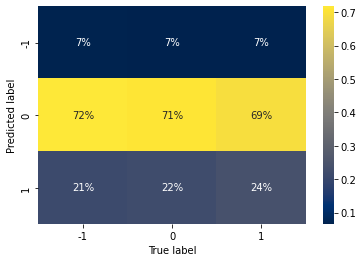

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Create the confusion matrix
conf_mat = confusion_matrix(concat_ALL['y_test_label'], concat_ALL['BERT_n'], normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel("True label")
plt.ylabel("Predicted label")

In [ ]:

print(classification_report(concat_ALL['BERT_n'], concat_ALL['y_test_label']))

print(accuracy_score(concat_ALL['BERT_n'], concat_ALL['y_test_label']))

print(multilabel_confusion_matrix(concat_ALL['BERT_n'], concat_ALL['y_test_label']))

              precision    recall  f1-score   support

        -1.0       0.07      0.02      0.03       284
         0.0       0.71      0.93      0.81      2971
         1.0       0.24      0.05      0.08       923

    accuracy                           0.68      4178
   macro avg       0.34      0.34      0.31      4178
weighted avg       0.56      0.68      0.60      4178

0.6766395404499761
[[[3815   79]
  [ 278    6]]

 [[  84 1123]
  [ 197 2774]]

 [[3106  149]
  [ 876   47]]]


In [ ]:
#accuracy = accuracy_score(lula_df['sentimento'], lula_df['LeIA_label_num'])
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(lula_df['LeIA_label_num'].astype(int).tolist(), lula_df['sentimento'].astype(int).tolist())
from sklearn import metrics
print("None ", metrics.precision_score(lula_df['LeIA_label_num'], lula_df['sentimento'], average=None))


In [ ]:
print(lula_df['sentimento'].count())

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment_result(sent):
    scores = analyzer.polarity_scores(sent)

    if scores["neg"] > scores["pos"]:
        return 0

    return 1

test_set["vader_result"] = test_set["review"].apply(lambda x: vader_sentiment_result(x))

accuracy = accuracy_score(test_set["sentiment"], test_set["vader_result"])


In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [ ]:
from evaluate import evaluator
task_evaluator = evaluator("sentiment-analysis")
results = task_evaluator.compute(
    model_or_pipeline="huggingface/prunebert-base-uncased-6-finepruned-w-distil-mnli",
    data=data,
    metric="accuracy",
    label_mapping={"LABEL_0": 0.0, "LABEL_1": 1.0},
    strategy="bootstrap",
    n_resamples=10,
    random_state=0
)

In [ ]:
sentiments = ['Positivo', 'Neutro', 'Negativo']
percents = [por_total_posb, por_total_negb]
pie_chart = pd.Series(percents, index=sentiments, name='Sentimentos')
colors = ['#ff9999','#66b3ff']
textprops = {"fontsize":10}
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(8, 8), colors=colors, textprops = textprops, labeldistance=1.2)
plt.title('Análise de sentimento dos tuítes de Bolsonaro por porcentagem', loc='center',fontsize=20)
plt.legend(labels=sentiments, loc='upper center',
           bbox_to_anchor=(0.5, -0.04), ncol=2)

plt.show()

In [ ]:
# plot impact of brier score with imbalanced datasets
from sklearn.metrics import brier_score_loss
from matplotlib import pyplot
from numpy import array
# define an imbalanced dataset
testy = y_test_lula
# brier score for predicting different fixed probability values
predictions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
losses = [brier_score_loss(testy, [y for x in range(len(testy))]) for y in predictions]
# plot predictions vs loss
pyplot.plot(predictions, losses)
pyplot.show()

In [ ]:
from imblearn.metrics import geometric_mean_score
geometric_mean_score(y_true, y_pred, average='macro')
geometric_mean_score(y_true, y_pred, average='weighted')


#####Bolsonaro

In [ ]:
input = X_test_bolsonaro.to_list()
output = classifier(input)


In [ ]:
print(type(output))
out = pd.DataFrame(output)
out.to_csv('/output_b.csv', header=True, index=False, encoding='UTF8')

<class 'list'>


In [ ]:
outout = pd.read_csv('/output_b.csv', encoding='utf8')


In [ ]:
threshold = 0.3

predictions_bolsonaro = []
for prediction in output:
  for x in prediction:
    if x['score']>=threshold:
      predictions_bolsonaro.append(x)

In [ ]:
labels_bolsonaro = list()

for i in range(len(predictions_bolsonaro)):
  pred = predictions_bolsonaro[i]
  labels_bolsonaro.append(pred)

labels_bolsonaro = pd.DataFrame(labels_bolsonaro)
print(labels)

#lula_df['sentimento'] = labels['label']
#lula_df['score'] = labels['score']
results_b = pd.DataFrame(labels_bolsonaro['label'])
results_b['score'] = labels_bolsonaro['score']
unique_labels = results_b['label'].unique()

[{'label': 'admiração', 'score': 0.41150906682014465}, {'label': 'neutro', 'score': 0.9261256456375122}, {'label': 'neutro', 'score': 0.969854474067688}, {'label': 'gratidão', 'score': 0.30766335129737854}, {'label': 'neutro', 'score': 0.821234941482544}, {'label': 'neutro', 'score': 0.9595038294792175}, {'label': 'amor', 'score': 0.9800183176994324}, {'label': 'neutro', 'score': 0.9443491101264954}, {'label': 'neutro', 'score': 0.9365743398666382}, {'label': 'neutro', 'score': 0.9692204594612122}, {'label': 'neutro', 'score': 0.9607932567596436}, {'label': 'neutro', 'score': 0.970840334892273}, {'label': 'curiosidade', 'score': 0.464318186044693}, {'label': 'neutro', 'score': 0.8526032567024231}, {'label': 'gratidão', 'score': 0.9924439787864685}, {'label': 'neutro', 'score': 0.9805835485458374}, {'label': 'gratidão', 'score': 0.9894664883613586}, {'label': 'neutro', 'score': 0.9799684286117554}, {'label': 'neutro', 'score': 0.5166027545928955}, {'label': 'neutro', 'score': 0.97108960

In [ ]:
labels_boas = ['desejo', 'admiração', 'amor', 'otimismo', 'realização','gratidão', 'diversão', 'entusiasmo', 'aprovação', 'alegria', 'zelo', 'alívio', 'curiosidade', 'percepção', 'surpresa', 'orgulho']
labels_neutras = ['neutro']
labels_ruins = ['raiva', 'aborrecimento', 'medo', 'nervosismo', 'desaprovação', 'decepção', 'tristeza', 'remorso', 'nojo', 'constrangimento', 'luto', 'confusão']
firstSet = set(labels_boas)
secondSet = set(labels_neutras)
thirdSet = set(labels_ruins)
bert=[]
#bolsonaro_df['bert_y_num'] = bolsonaro_df['sentimento'].apply(lambda x: 1 if x in firstSet else 0 if x in secondSet else -1 if x in thirdSet else x)
#bolsonaro_df['bert_y_cat'] = bolsonaro_df['sentimento'].apply(lambda x: 'Positivo' if x in firstSet else 'Neutro' if x in secondSet else 'Negativo' if x in thirdSet else x)
results_b['result_cat'] = results_b['label'].apply(lambda x: 'Positivo' if x in firstSet else 'Neutro' if x in secondSet else 'Negativo' if x in thirdSet else x)
results_b['result_num'] = results_b['label'].apply(lambda x: 1 if x in firstSet else 0 if x in secondSet else -1 if x in thirdSet else x)

results_b.tail()

label     score result_cat  result_num
3439    neutro  0.746573     Neutro           0
3440    neutro  0.924699     Neutro           0
3441    neutro  0.759125     Neutro           0
3442  diversão  0.625534   Positivo           1
3443    neutro  0.978699     Neutro           0

In [ ]:
import torch

#def sentiment_score(review):
  #  tokens = tokenizer.encode(review, return_tensors='pt')
  #  result = model(tokens)
  #  return int(torch.argmax(result.logits))+results_b['result_num'] = results_b['result_num']
#.astype("str")

results_b['tweet'] = X_test_bolsonaro
print(results_b['result_num'])
pred_bolsonaro_bert_n = pd.DataFrame(results_b['result_num'])
pred_bolsonaro_bert_n['result_num'] = pred_bolsonaro_bert_n['result_num'].astype("int")
#for i in range(1, 21):
for i in range(1, 163):
    pred_bolsonaro_bert_n = pred_bolsonaro_bert_n.append(pd.Series(), ignore_index = True)
#pred_lula_bert_n['result_num'] = pred_lula_bert_n['result_num'].astype("int")


0       1
1       0
2       0
3       1
4       0
       ..
3395    0
3396    0
3397    1
3398    0
3399    0
Name: result_num, Length: 3400, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


In [ ]:
pred_bolsonaro_bert_c = pd.DataFrame(results_b['result_cat'])
for i in range(1, 163):
    pred_bolsonaro_bert_c = pred_bolsonaro_bert_c.append(pd.Series(), ignore_index = True)

#pred_bolsonaro_bert_n = pred_bolsonaro_bert_n.fillna(int(0))
#pred_bolsonaro_bert_c = pred_bolsonaro_bert_c.fillna(int(0))

concat_ALL_b = pd.DataFrame()

concat_ALL_b['BERT_n'] = pred_bolsonaro_bert_n
concat_ALL_b['BERT_c'] = concat_ALL_b['BERT_n'].apply(lambda x: 'Positivo' if x == 1 else 'Neutro' if x == 0 else 'Negativo' if x == -1 else x)
#concat_ALL_b['BERT_c'] = pred_bolsonaro_bert_c
concat_ALL_b['LeIA_n'] = pred_bolsonaro
concat_ALL_b['LeIA_c'] = concat_ALL_b['LeIA_n'].apply(lambda x: 'Positivo' if x == 1 else 'Neutro' if x == 0 else 'Negativo' if x == -1 else x)
concat_ALL_b['y_test_label'] = pd.Series(y_test_bolsonaro)

concat_ALL_b.dropna(axis = 0, how = 'any', inplace = True)
concat_ALL_b.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


BERT_n    BERT_c  LeIA_n    LeIA_c  y_test_label
0     1.0  Positivo       0    Neutro             0
1     0.0    Neutro       0    Neutro             0
2     0.0    Neutro      -1  Negativo             0
3     1.0  Positivo       0    Neutro             0
4     0.0    Neutro       0    Neutro             0

              precision    recall  f1-score   support

        -1.0       0.03      0.01      0.01       149
         0.0       0.74      0.92      0.82      2529
         1.0       0.25      0.08      0.12       722

    accuracy                           0.70      3400
   macro avg       0.34      0.34      0.32      3400
weighted avg       0.61      0.70      0.64      3400

0.7014705882352941
[[[3214   37]
  [ 148    1]]

 [[  73  798]
  [ 205 2324]]

 [[2498  180]
  [ 662   60]]]


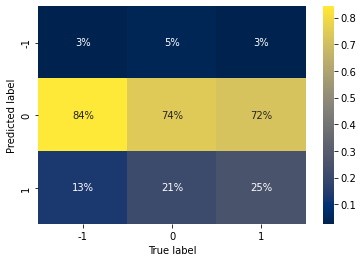

In [ ]:
conf_mat = confusion_matrix(concat_ALL_b['y_test_label'], concat_ALL_b['BERT_n'], normalize="true")

sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel("True label")
plt.ylabel("Predicted label")

print(classification_report(concat_ALL_b['BERT_n'], concat_ALL_b['y_test_label']))
print(accuracy_score(concat_ALL_b['BERT_n'], concat_ALL_b['y_test_label']))
print(multilabel_confusion_matrix(concat_ALL_b['BERT_n'], concat_ALL_b['y_test_label']))

###vem aí

In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def removeStopWord(text):
  stopwords =

In [ ]:
import spacy
nlp = spacy.load("pt_core_news_sm")

OSError: ignored